In [21]:
import sys, importlib
importlib.reload(sys.modules['sf_runoff'])

<module 'sf_runoff' from 'C:\\Users\\mmazzolini\\OneDrive - Scientific Network South Tyrol\\Documents\\conda\\Runoff_prediction\\Snow_experiment\\..\\sf_runoff.py'>

In [1]:
import sys
sys.path.insert(0, "..")


from sf_runoff import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies, create_it_matrix
from nested_CV import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from test import evaluate_prediction, plot_prediction, plot_anomalies
from test import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
from classic_CV_predict import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import os
import pdb
import seaborn as sns

## A) ALL_VARS, T_UNIT = 30

In [16]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\old\\'

daily_input = pd.read_csv(path+'DROME_SAILLANS.csv', index_col=0, parse_dates=True)

daily_input_stat = spatial_stats_daily_input(daily_input)
#daily_input_stat=daily_input_stat[daily_input_stat.index.dayofyear%2==1]

t_unit= 30


#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-1.5, 0.5, 7)
epsilon_range=np.logspace(-2.5, -0.5, 4)

#do not enlarge t_range for now
t_range=[12]
t_length=t_range[0]
n_splits=5
test_size=365


daily_input_stat=daily_input_stat.iloc[2:]

In [92]:
daily_input_stat

Q           T          T5         T25         T75         T95  \
time                                                                            
1979-01-03   7.00  266.476581  263.708992  265.765733  267.239306  269.021700   
1979-01-04   6.30  270.409717  268.247577  269.549046  271.114793  272.916299   
1979-01-05   5.97  270.238963  268.225209  269.179454  271.065458  273.137470   
1979-01-06   5.64  269.659783  267.470280  268.717125  270.482599  272.429532   
1979-01-07   5.31  269.861844  267.960658  269.209420  270.596758  272.373126   
...           ...         ...         ...         ...         ...         ...   
2018-12-27  31.40  273.228046  271.897589  272.425830  273.791324  274.995451   
2018-12-28  28.00  273.918876  272.373803  273.232563  274.532930  275.811673   
2018-12-29  25.70  273.783682  272.123318  273.248986  274.350121  275.584285   
2018-12-30  23.60  273.909291  272.385433  273.248355  274.453462  275.704665   
2018-12-31  21.80  274.599634  272.900360  274.010646  275.162709  276.717942   

                   E        E5       E25       E75  ...         S    S5  S25  \
time                                                ...                        
1979-01-03  0.282859  0.146444  0.218784  0.353783  ...  5.000000  3.75  4.0   
1979-01-04  0.440302  0.344666  0.406471  0.465039  ...  6.638889  4.00  5.0   
1979-01-05 -0.027579 -0.143144 -0.074284  0.033328  ...  6.638889  4.00  5.0   
1979-01-06 -0.053625 -0.125028 -0.089807 -0.016917  ...  6.638889  4.00  5.0   
1979-01-07  0.443700  0.278821  0.396273  0.501930  ...  6.694444  4.00  5.0   
...              ...       ...       ...       ...  ...       ...   ...  ...   
2018-12-27  0.091023 -0.123783 -0.034318  0.200427  ...  2.000000  0.00  0.0   
2018-12-28  0.177956  0.081577  0.116912  0.206109  ...  2.000000  0.00  0.0   
2018-12-29  0.205498  0.084089  0.142601  0.249667  ...  2.000000  0.00  0.0   
2018-12-30  0.247289  0.155985  0.182822  0.308875  ...  1.972222  0.00  0.0   
2018-12-31  0.286023  0.204272  0.253603  0.321550  ...  1.916667  0.00  0.0   

            S75    S95    R   R5  R25  R75  R95  
time                                             
1979-01-03  6.0   7.25  0.0  0.0  0.0  0.0  0.0  
1979-01-04  8.0  10.00  0.0  0.0  0.0  0.0  0.0  
1979-01-05  8.0  10.00  0.0  0.0  0.0  0.0  0.0  
1979-01-06  8.0  10.00  0.0  0.0  0.0  0.0  0.0  
1979-01-07  8.0  10.00  0.0  0.0  0.0  0.0  0.0  
...         ...    ...  ...  ...  ...  ...  ...  
2018-12-27  0.0  15.00  0.0  0.0  0.0  0.0  0.0  
2018-12-28  0.0  15.00  0.0  0.0  0.0  0.0  0.0  
2018-12-29  0.0  15.00  0.0  0.0  0.0  0.0  0.0  
2018-12-30  0.0  14.75  0.0  0.0  0.0  0.0  0.0  
2018-12-31  0.0  14.00  0.0  0.0  0.0  0.0  0.0  

[14608 rows x 26 columns]

Fitting 1 folds for each of 28 candidates, totalling 28 fits
Fitting 1 folds for each of 28 candidates, totalling 28 fits
Fitting 1 folds for each of 28 candidates, totalling 28 fits
Fitting 1 folds for each of 28 candidates, totalling 28 fits
Fitting 1 folds for each of 28 candidates, totalling 28 fits

C3=0.14677992676220694
eps3=0.06812920690579612


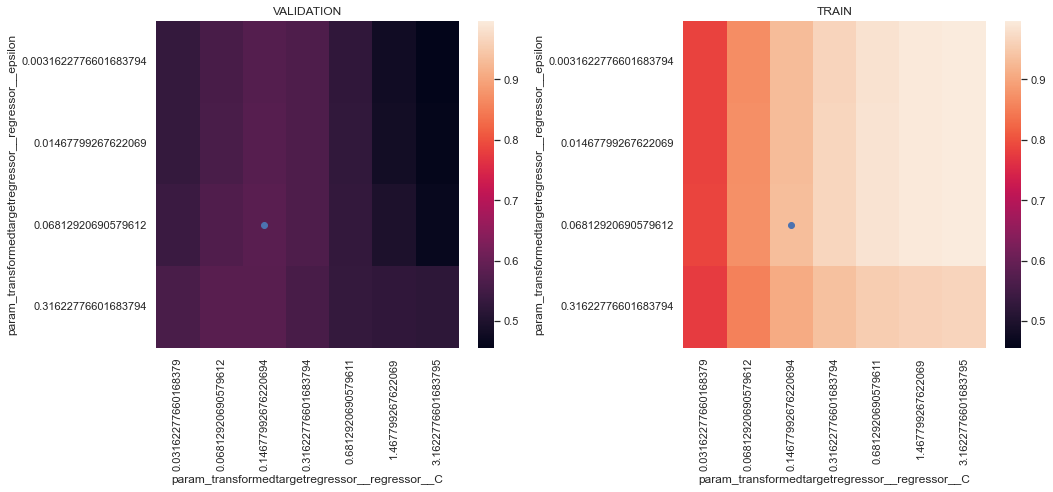

In [17]:
C, eps = SVR_nested_CV_gridsearch(daily_input_stat, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C3={C}')
print(f'eps3={eps}')

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [18]:
radius_for_ensemble = 1
predictions = nested_CV_SVR_predict(daily_input_stat, C, eps, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

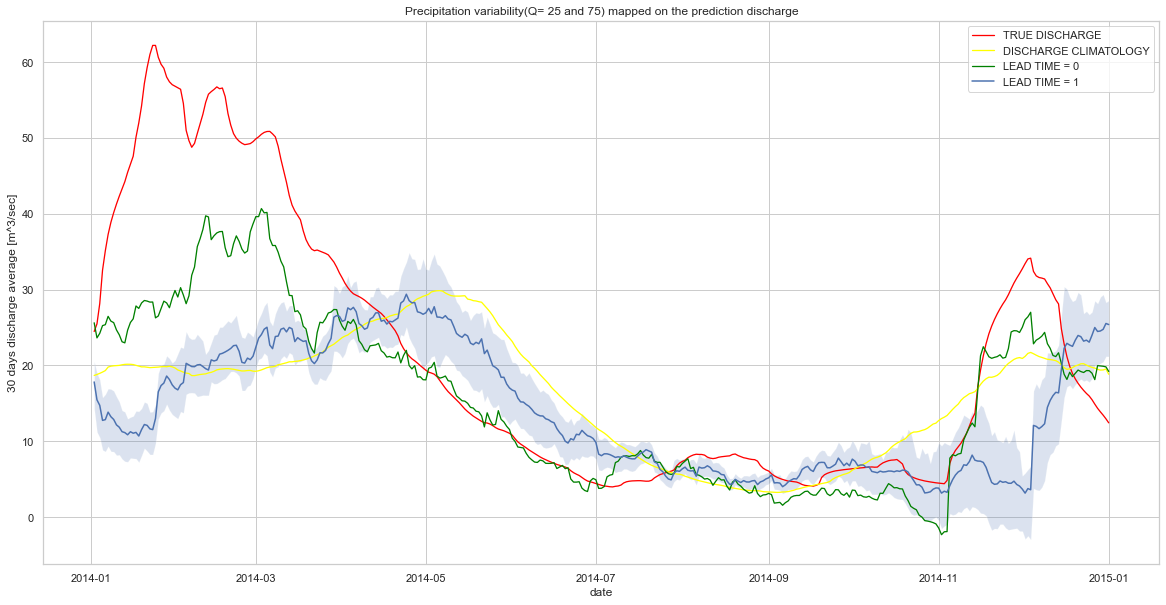

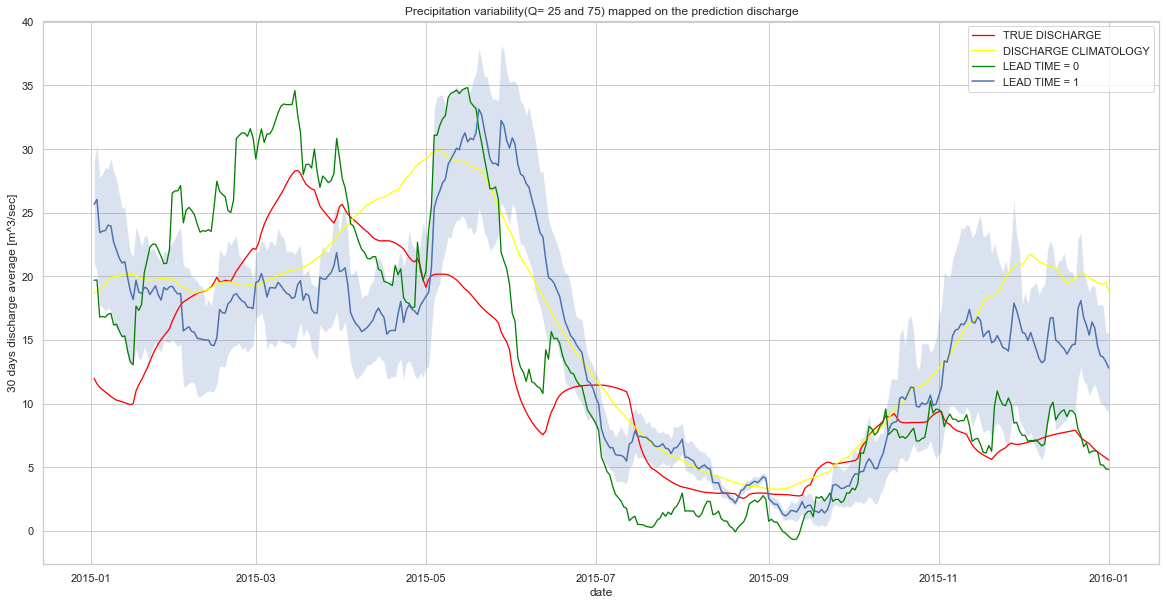

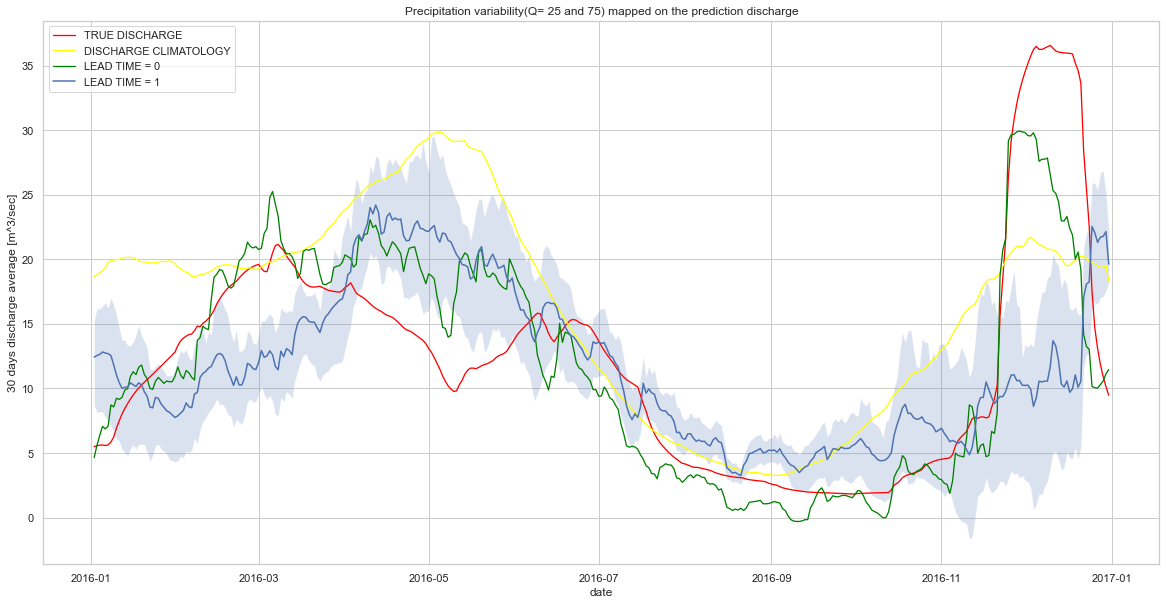

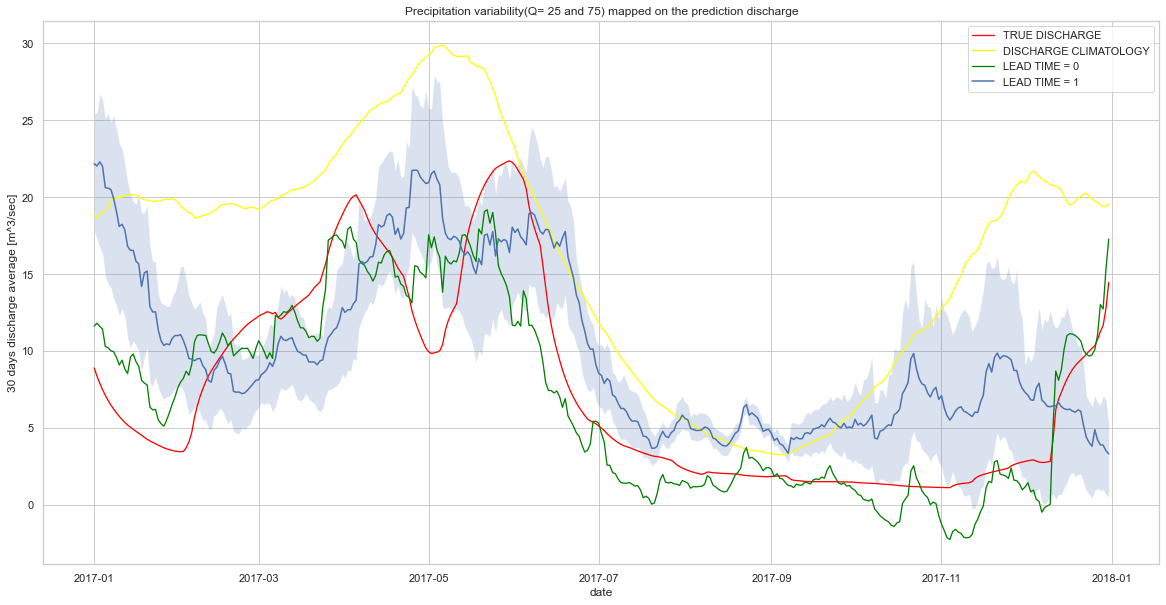

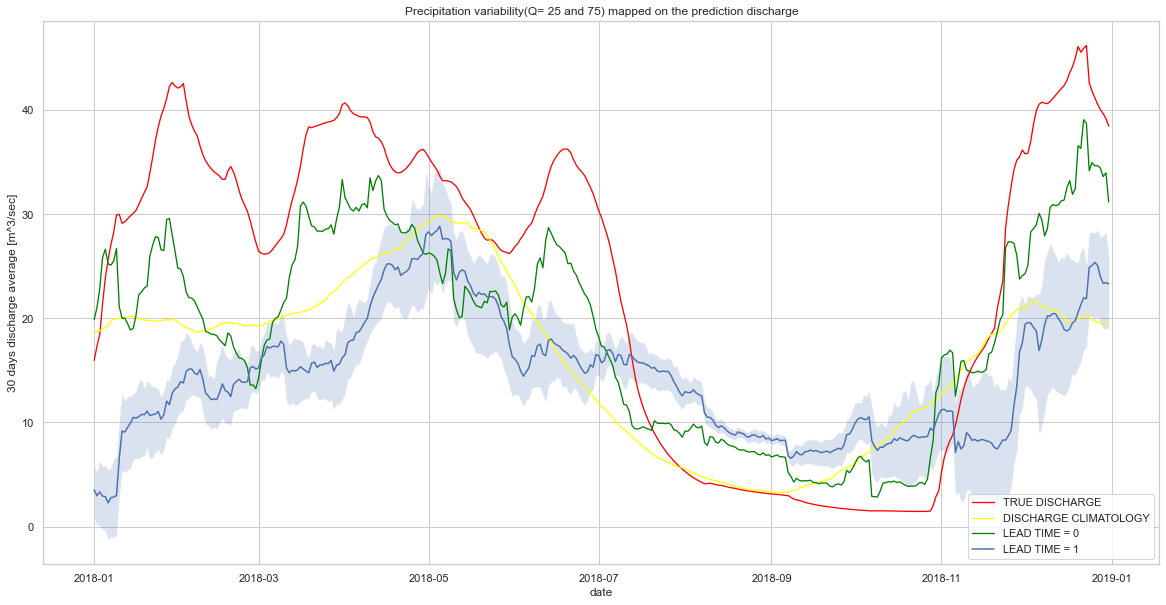

In [19]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions)

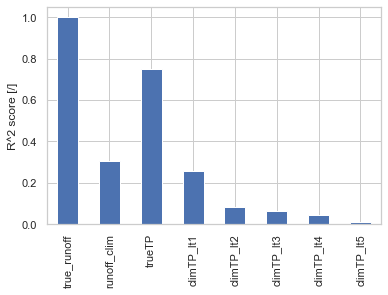

In [20]:
r2_A= evaluate_prediction(predictions)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [21]:
predictions_for_clim = classic_CV_SVR_predict(daily_input_stat, C, eps, t_length,t_unit, n_splits)

In [22]:
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index


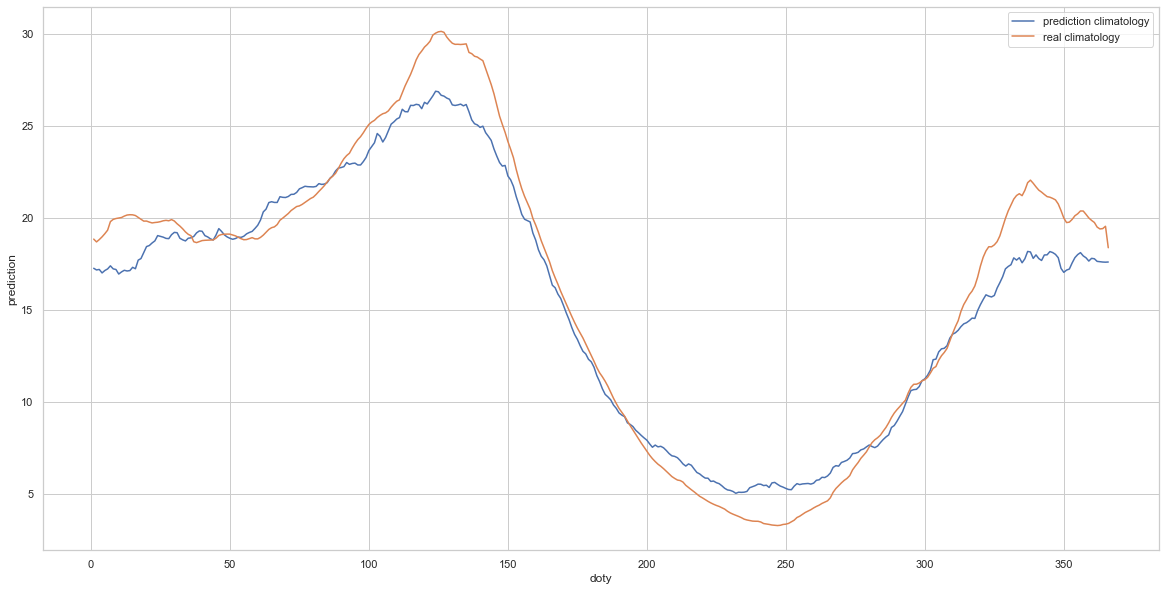

In [23]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

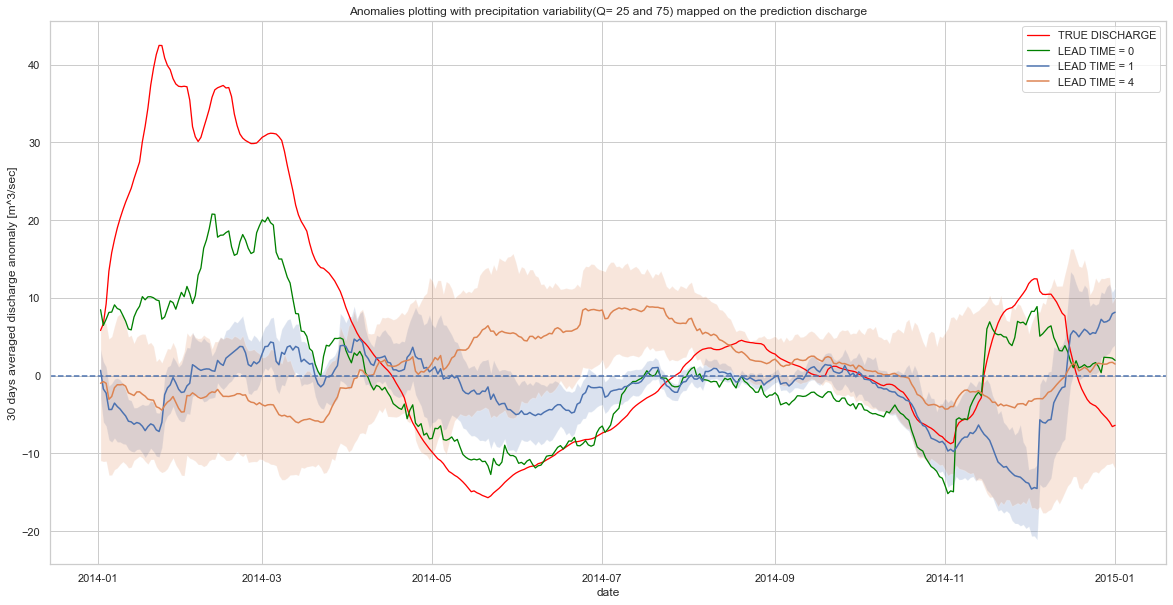

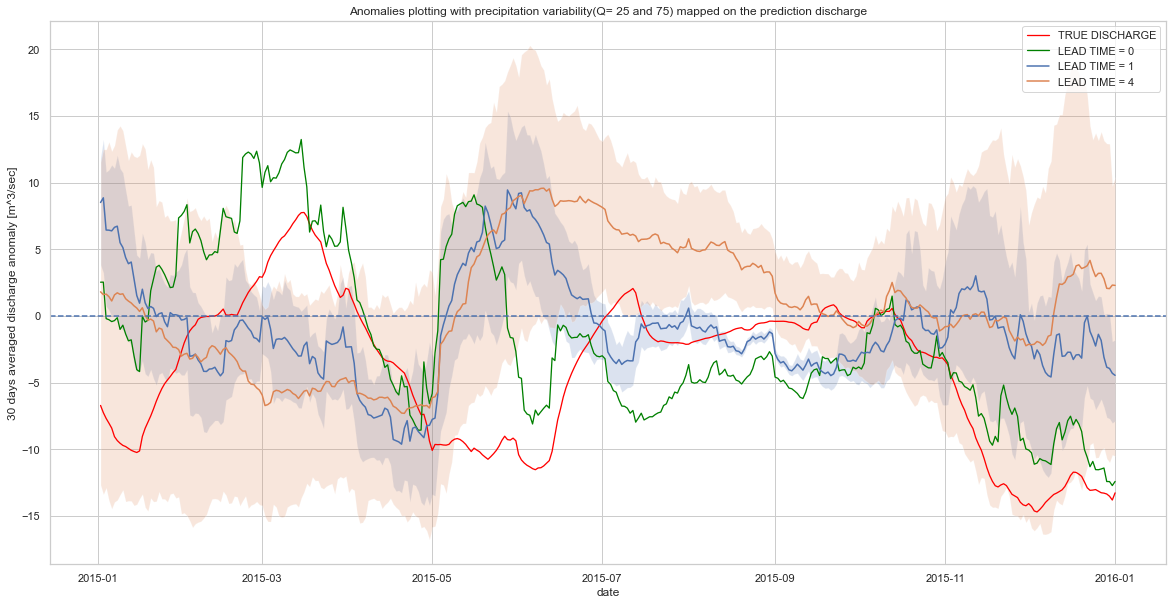

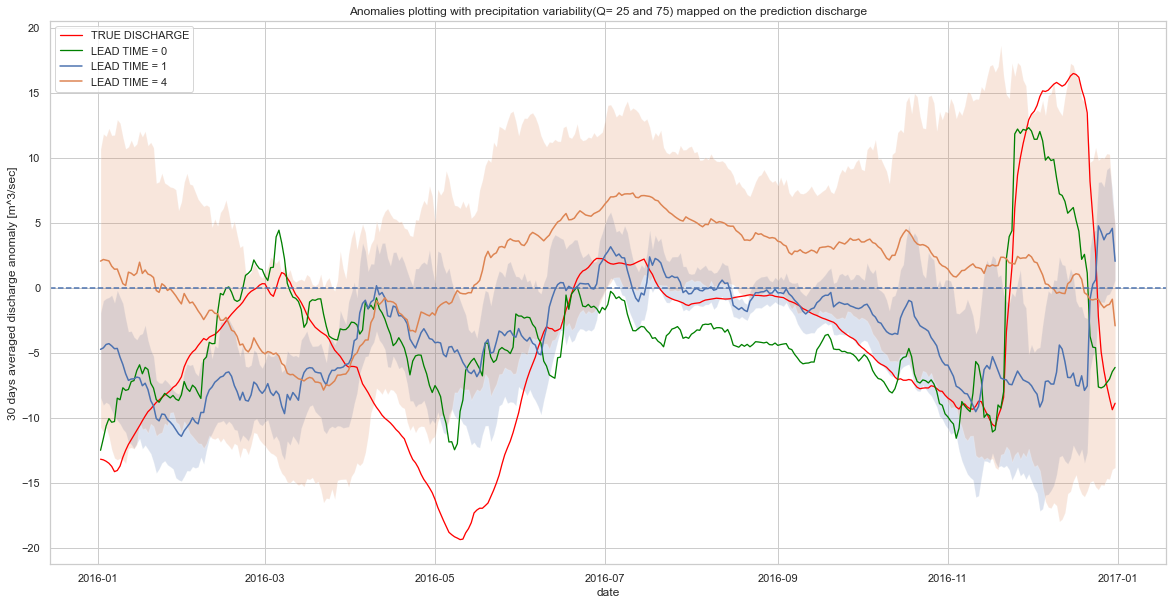

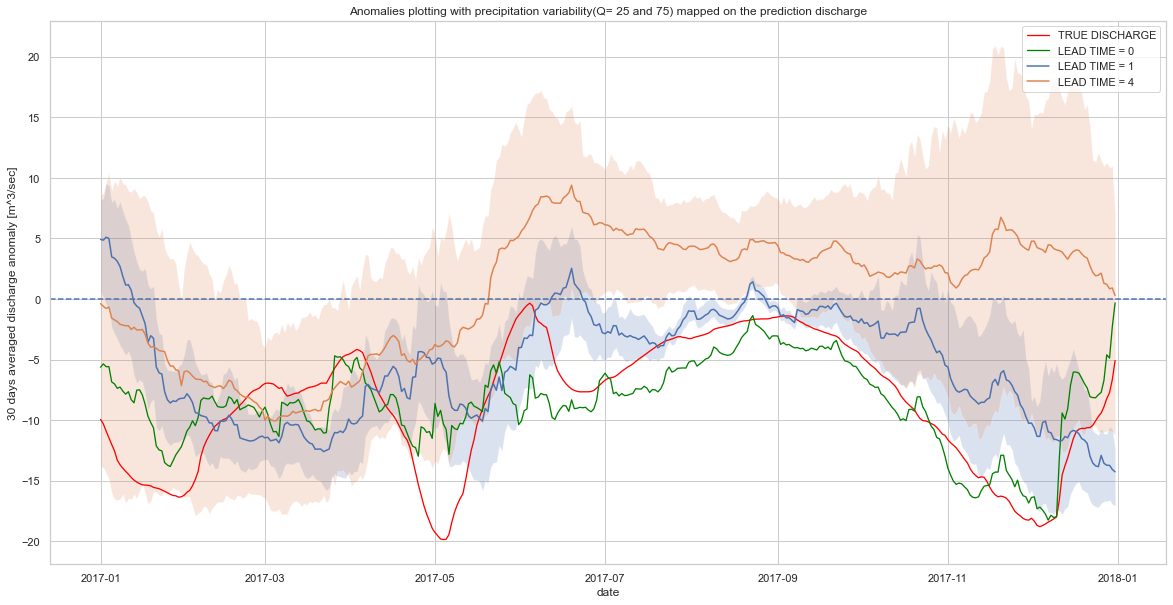

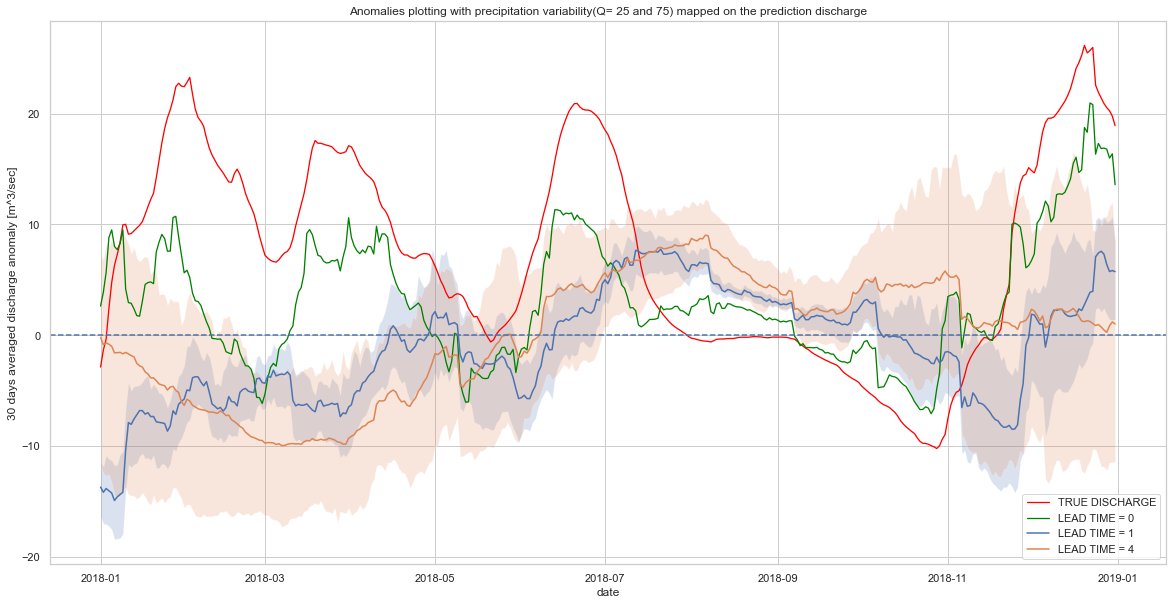

In [24]:
a=compute_anomalies(climatologies, predictions)
a['split']=predictions.split

plot_anomalies(a)

## B) NO_SNOW, T_UNIT = 30

In [32]:
daily_input_stat2 = daily_input_stat.drop(columns=[c for c in daily_input_stat.columns if c[0]=='S'])


In [68]:
#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-1.5, 0, 5)
epsilon_range=np.logspace(-7, -4, 5)

#n_range = [17, 50, 200]
components_range = [5*4*36]
#do not enlarge t_range for now
t_range=[36]
t_length=t_range[0]
n_splits=5
test_size=365

Fitting 1 folds for each of 25 candidates, totalling 25 fits
Fitting 1 folds for each of 25 candidates, totalling 25 fits
Fitting 1 folds for each of 25 candidates, totalling 25 fits
Fitting 1 folds for each of 25 candidates, totalling 25 fits
Fitting 1 folds for each of 25 candidates, totalling 25 fits

C2=0.03162277660168379
eps2=1.778279410038923e-05


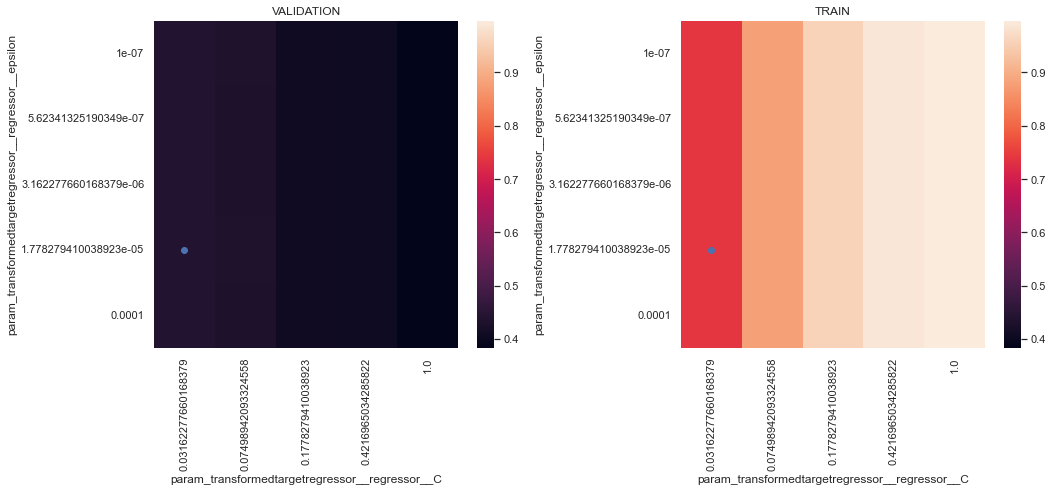

In [69]:
C2, eps2 = SVR_nested_CV_gridsearch(daily_input_stat2, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C2={C2}')
print(f'eps2={eps2}')

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [70]:
radius_for_ensemble = 1
predictions2 = nested_CV_SVR_predict(daily_input_stat2, C2, eps2, t_length, t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

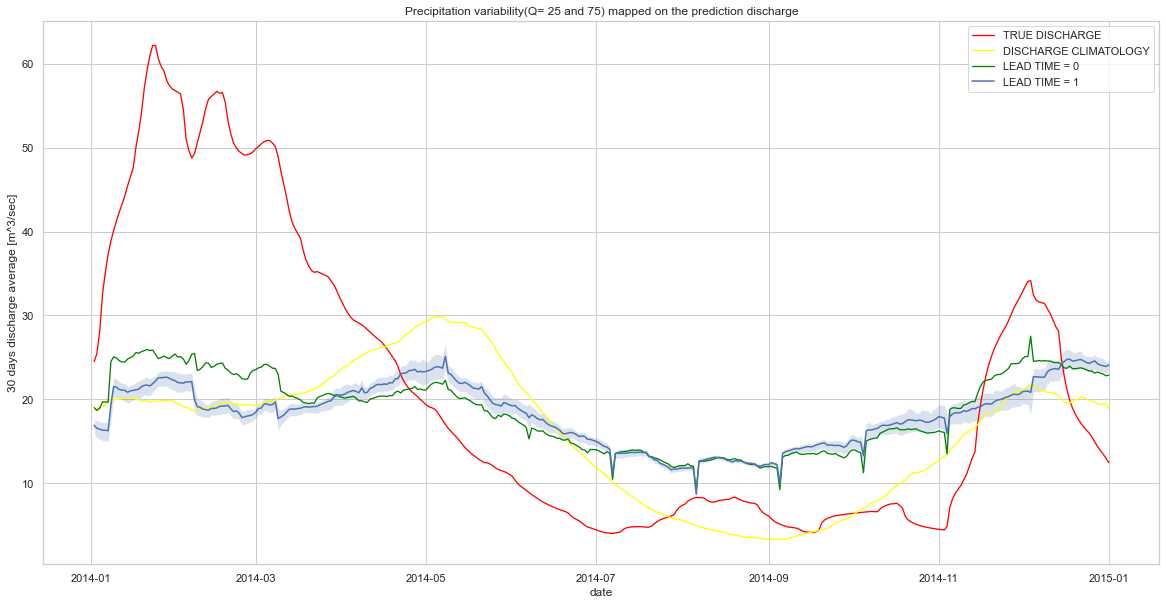

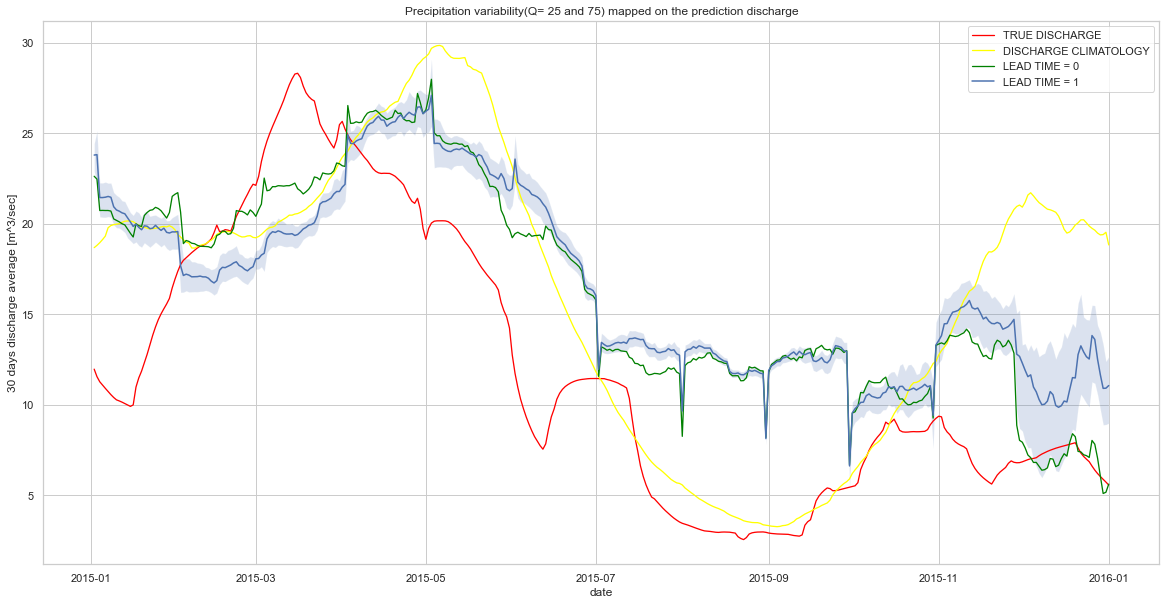

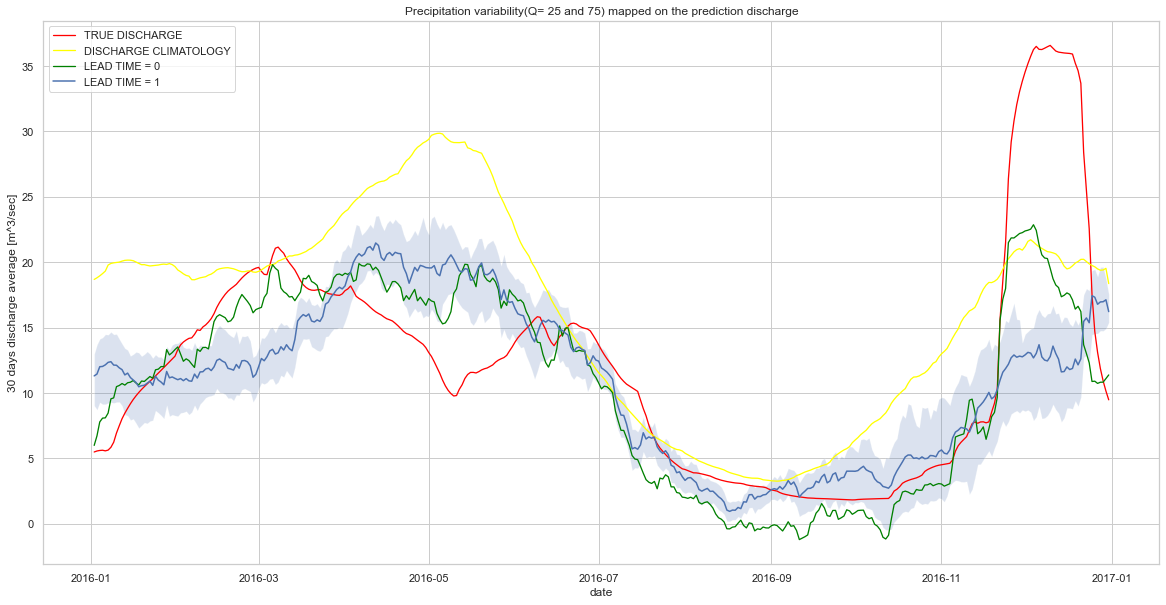

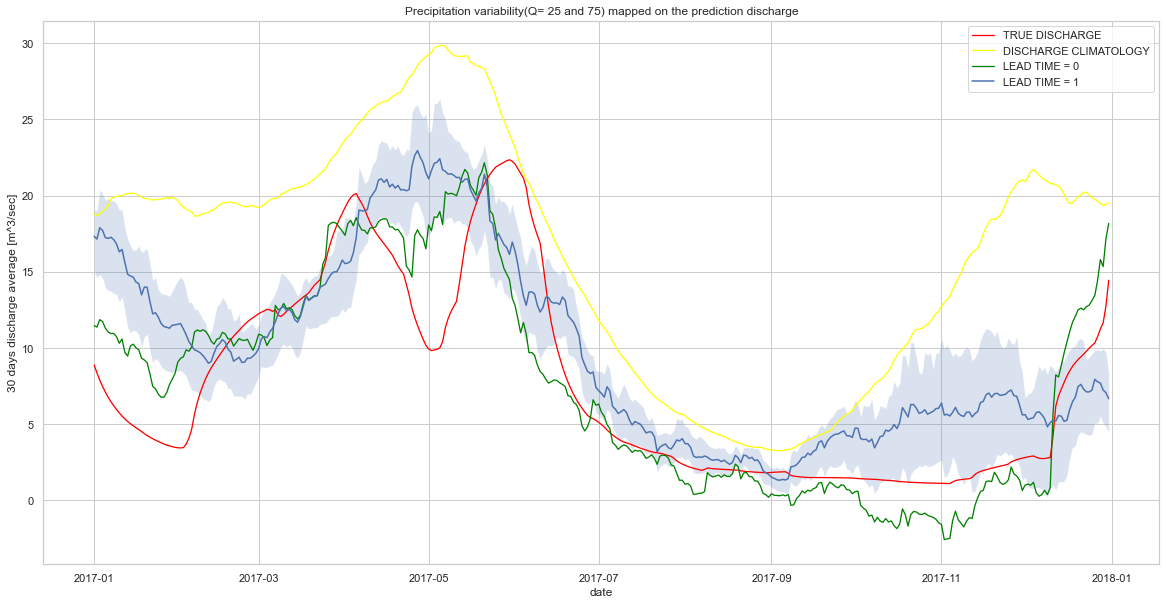

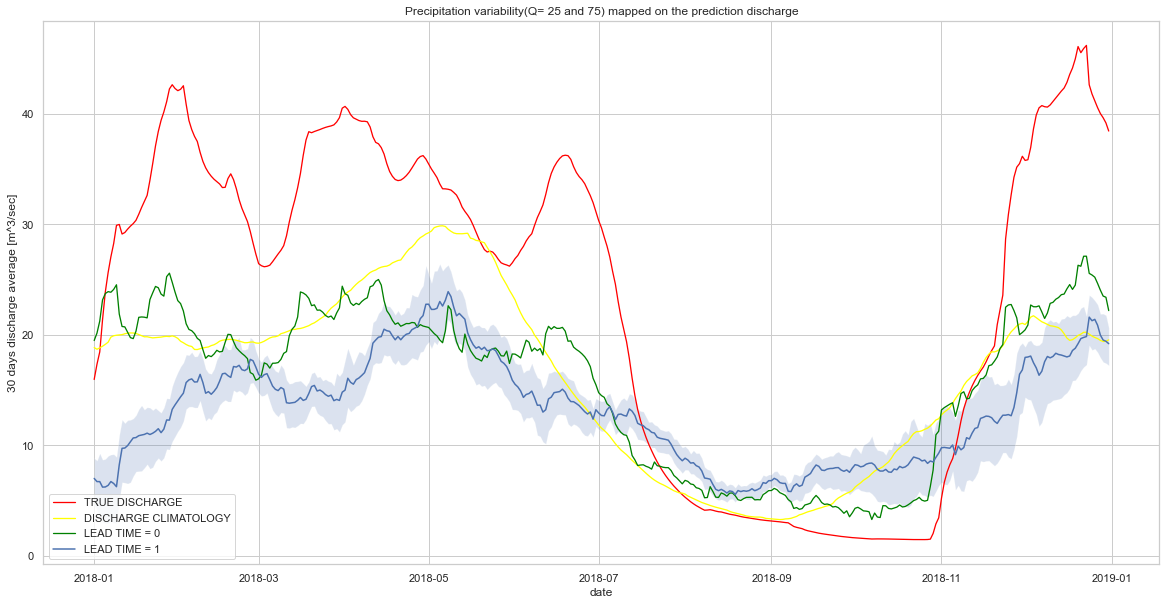

In [71]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions2)

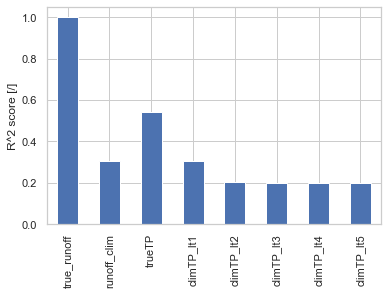

In [72]:
r2_B= evaluate_prediction(predictions2)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [73]:
predictions_for_clim2 = classic_CV_SVR_predict(daily_input_stat2, C2, eps2, t_length, t_unit, n_splits)

In [74]:
climatologies2 =predictions_for_clim2.groupby(by=predictions_for_clim2.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies2['doty']=climatologies2.index


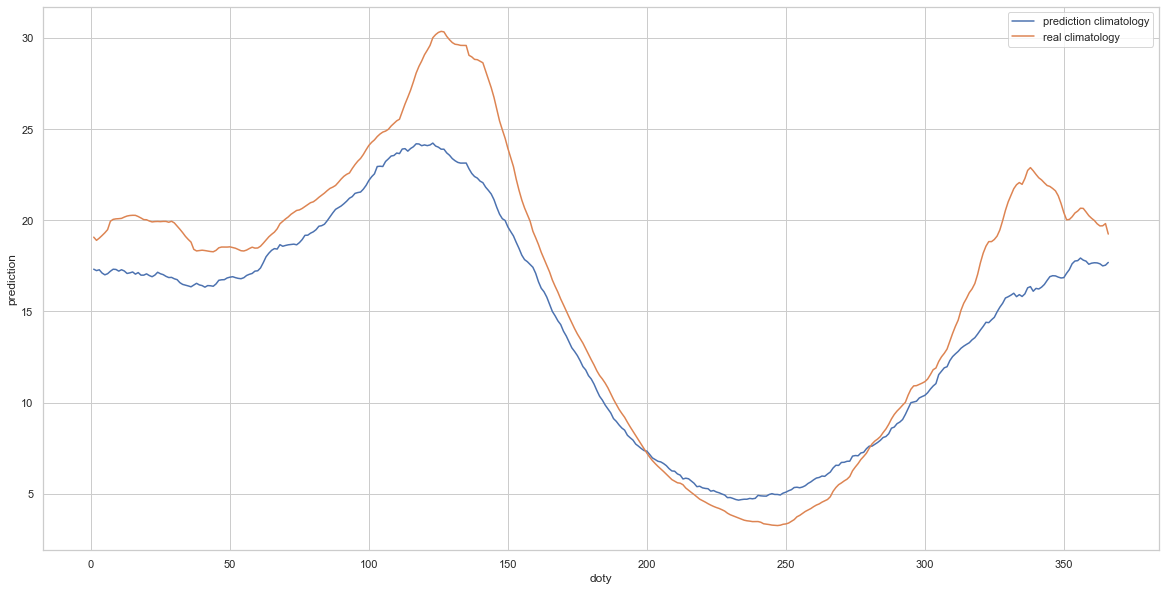

In [75]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies2,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies2,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

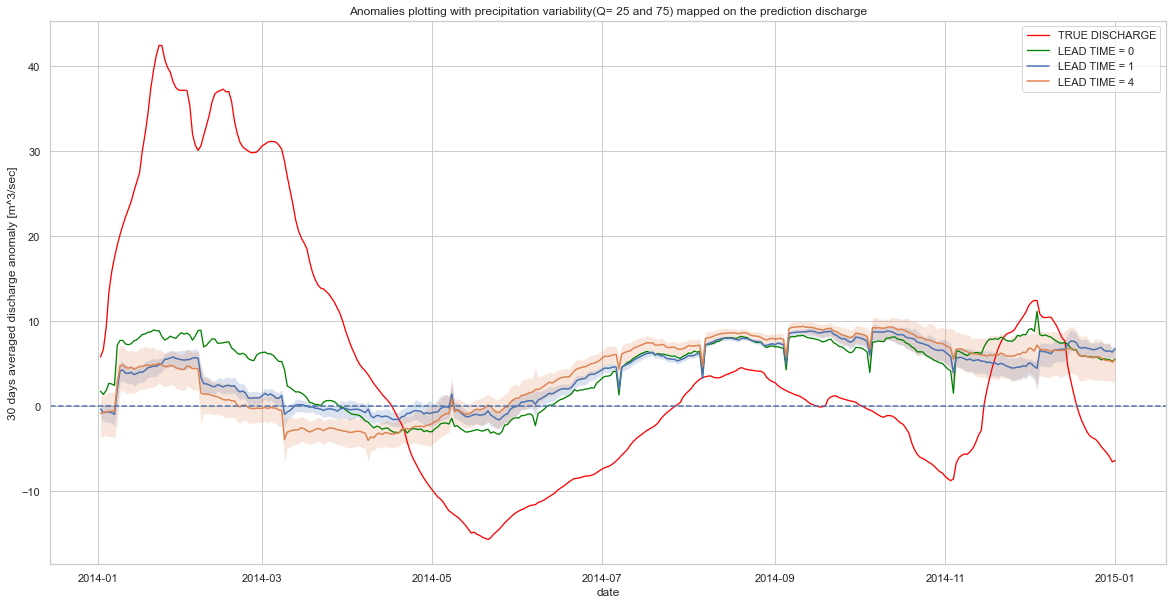

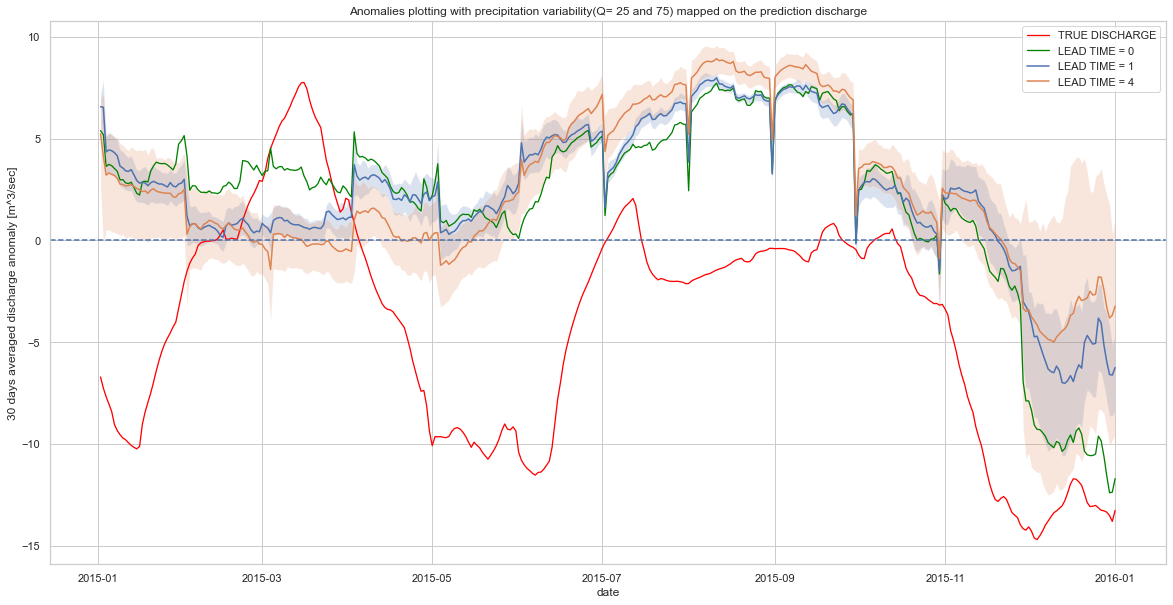

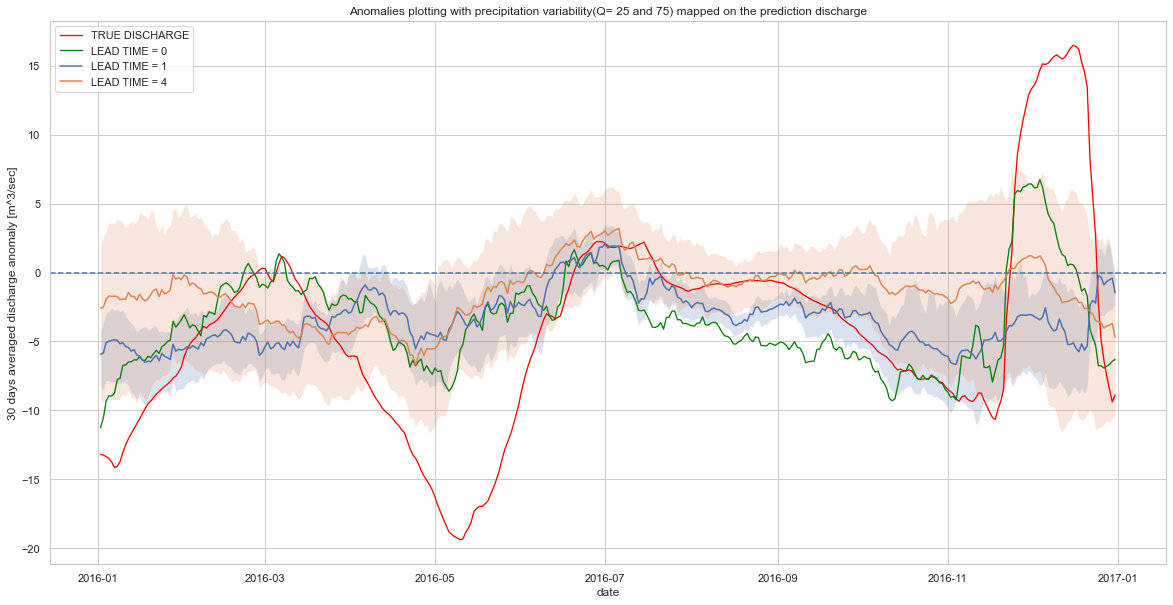

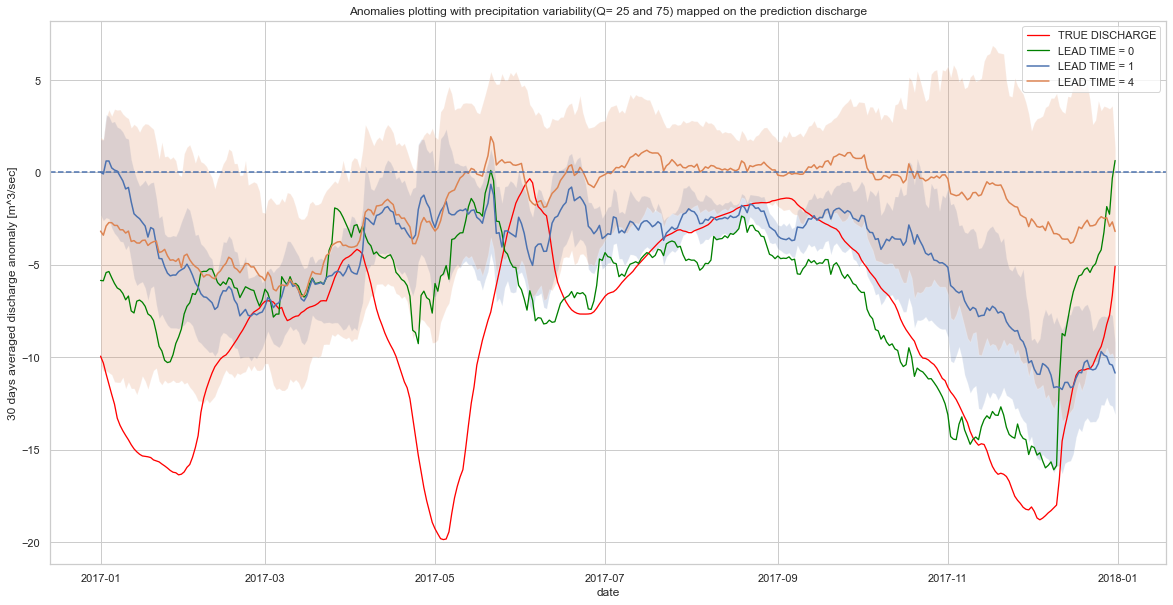

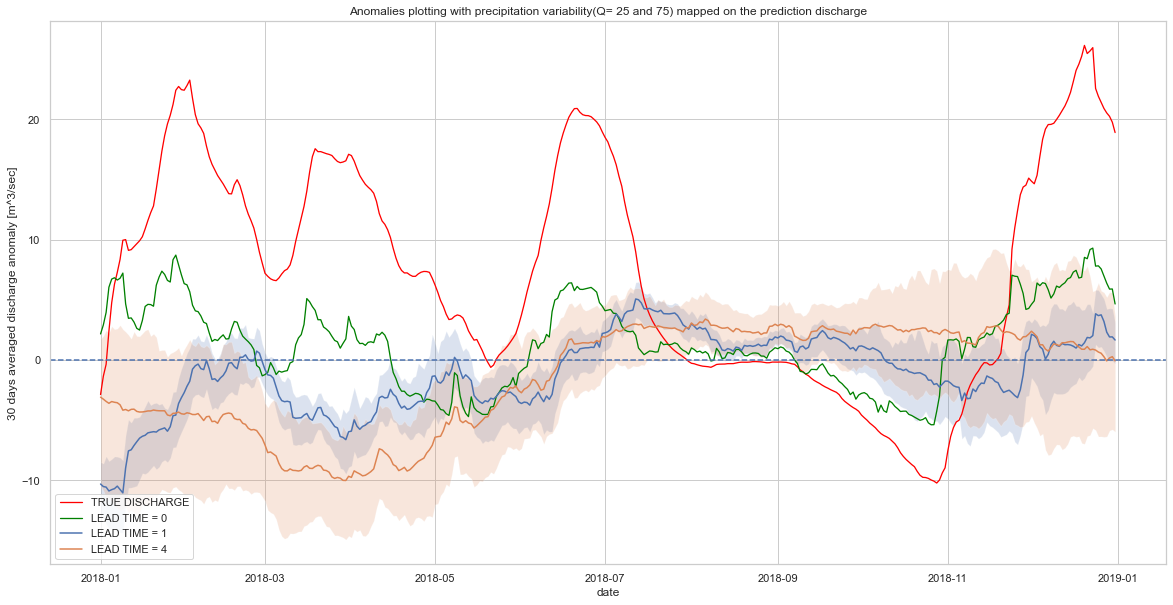

In [76]:
a2=compute_anomalies(climatologies2, predictions2)
a2['split']=predictions2.split

plot_anomalies(a2)

## C) NO_EVAP, T_UNIT = 30

In [77]:
daily_input_stat3 = daily_input_stat.drop(columns=[c for c in daily_input_stat.columns if c[0]=='E'])

t_unit=30

Fitting 1 folds for each of 25 candidates, totalling 25 fits
Fitting 1 folds for each of 25 candidates, totalling 25 fits
Fitting 1 folds for each of 25 candidates, totalling 25 fits
Fitting 1 folds for each of 25 candidates, totalling 25 fits
Fitting 1 folds for each of 25 candidates, totalling 25 fits

C3=0.07498942093324558
eps3=0.0001


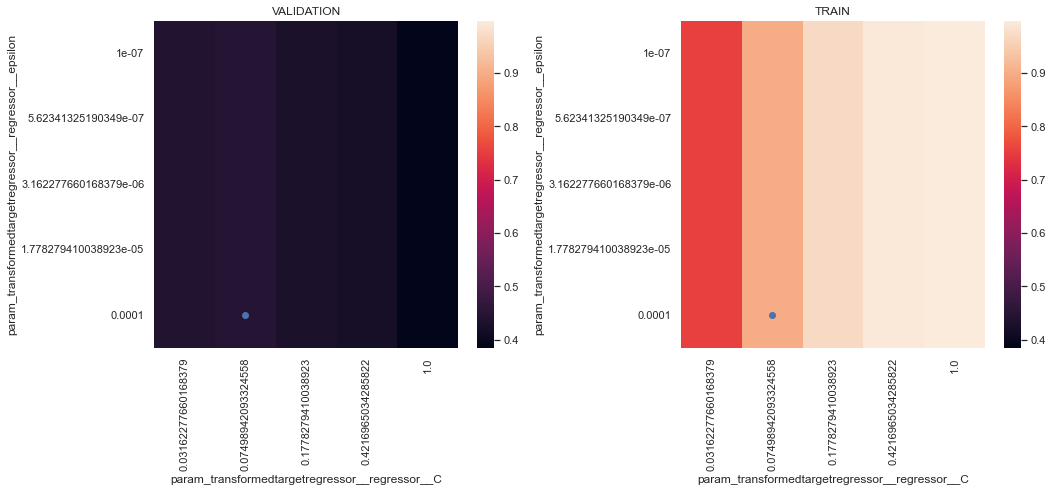

In [78]:
C3, eps3 = SVR_nested_CV_gridsearch(daily_input_stat3, C_range, epsilon_range, t_range, t_unit, n_splits, test_size)
print(f'C3={C3}')
print(f'eps3={eps3}')

C3=0.17782794100
eps3=0.316227766016

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [79]:
radius_for_ensemble = 1
predictions3 = nested_CV_SVR_predict(daily_input_stat3, C3, eps3, t_length, t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

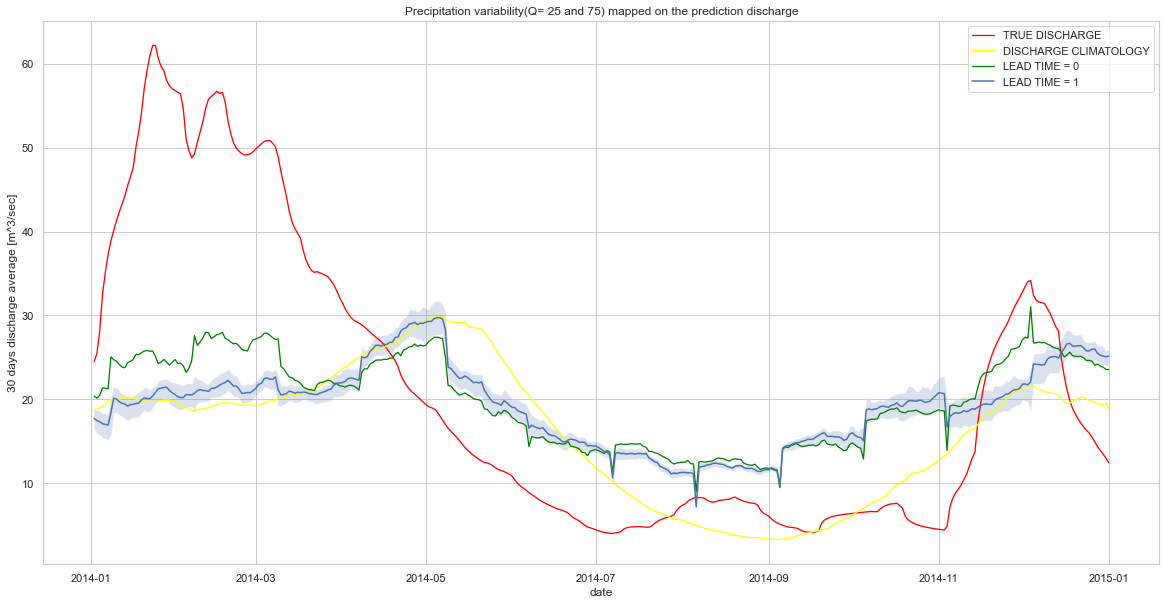

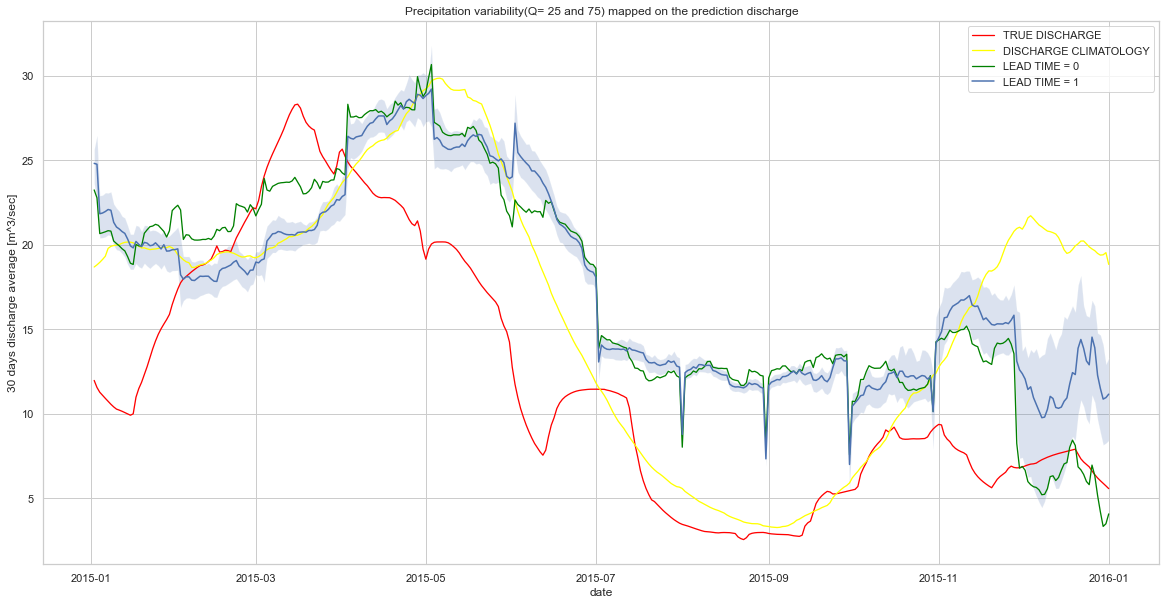

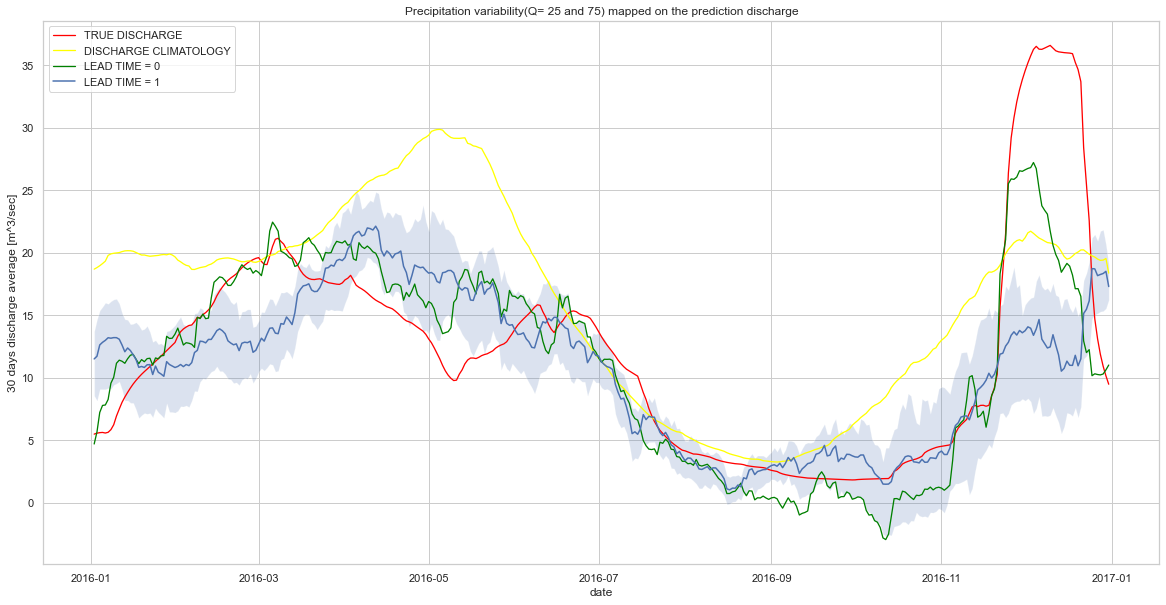

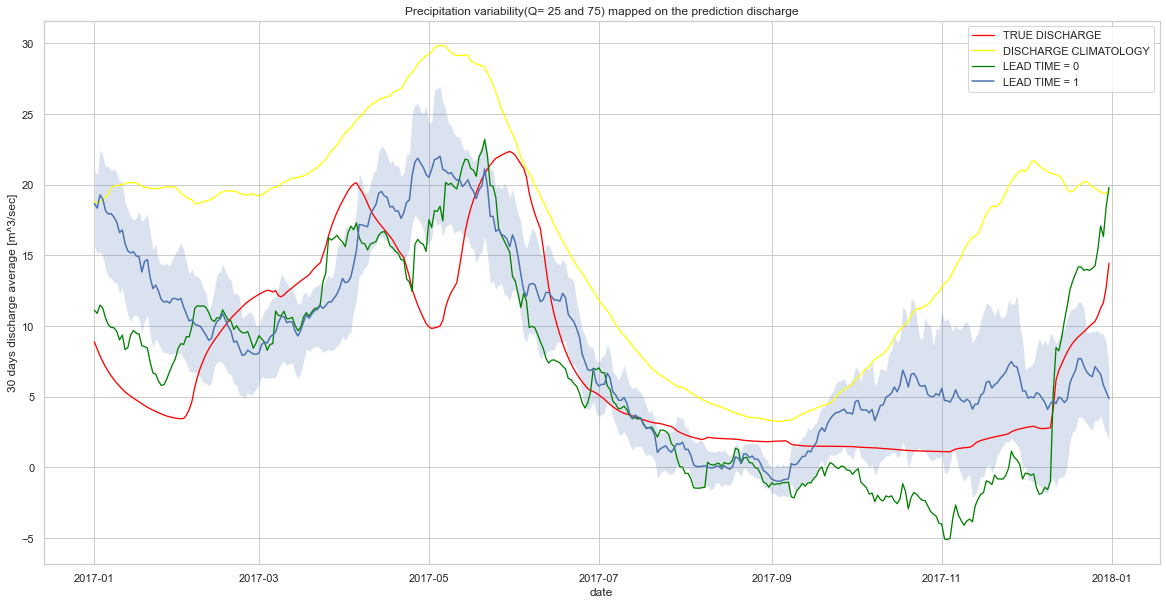

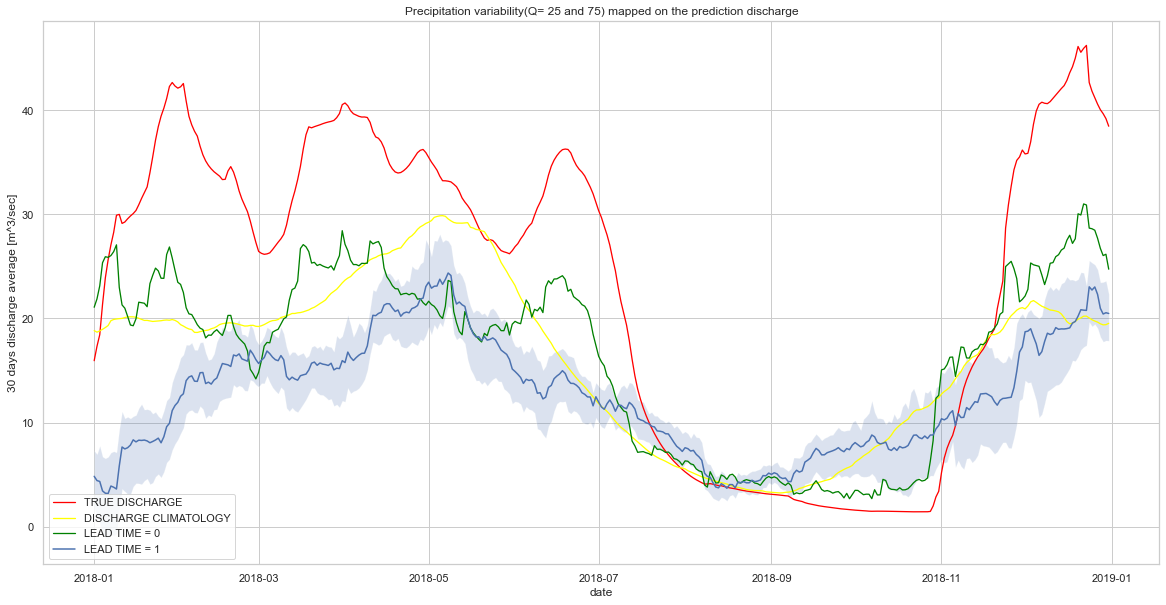

In [80]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions3)

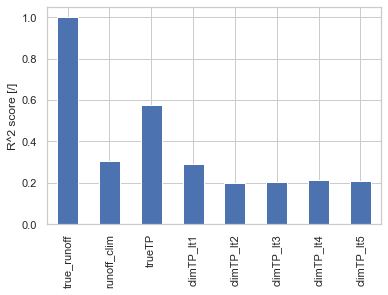

In [81]:
r2_C= evaluate_prediction(predictions3)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [82]:
predictions_for_clim3 = classic_CV_SVR_predict(daily_input_stat3, C3, eps3, t_length, t_unit, n_splits)

In [83]:
climatologies3 =predictions_for_clim3.groupby(by=predictions_for_clim3.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies3['doty']=climatologies3.index


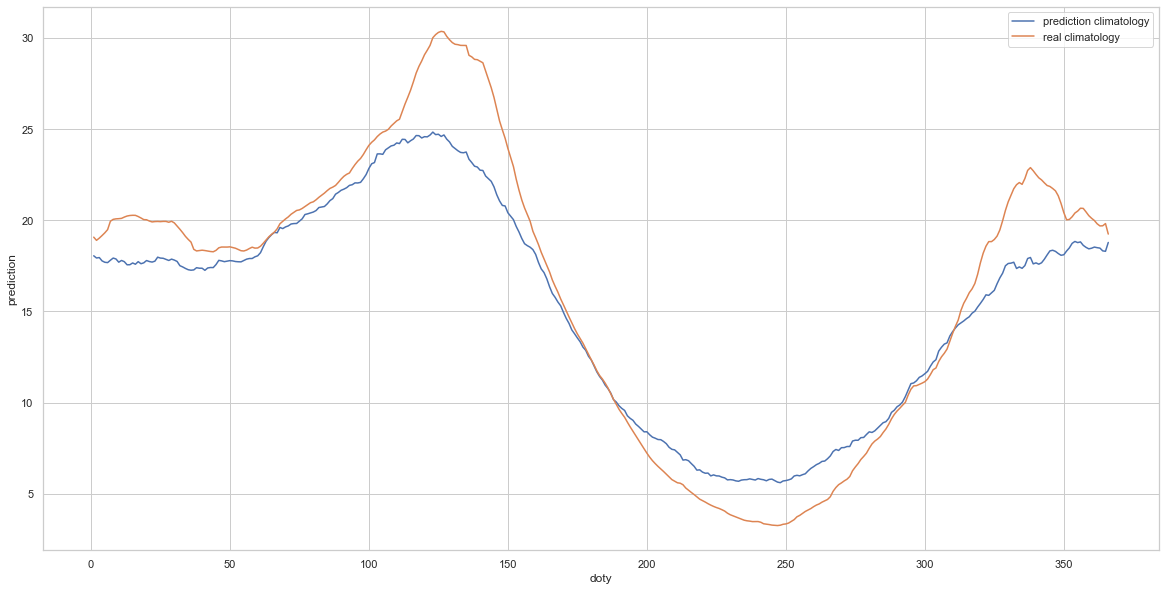

In [84]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies3,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies3,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

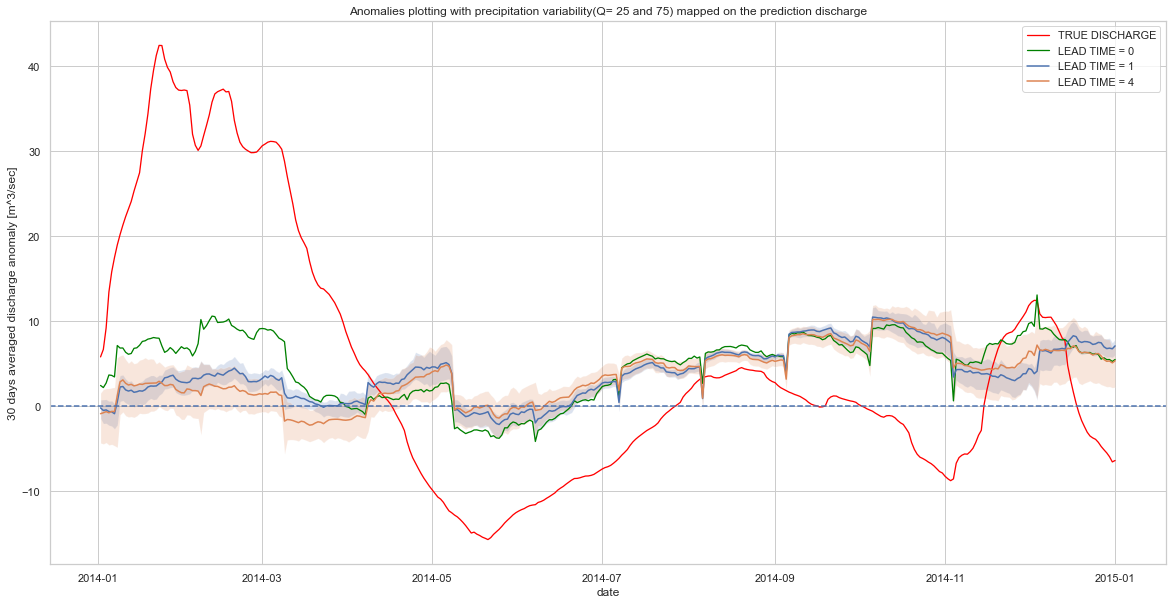

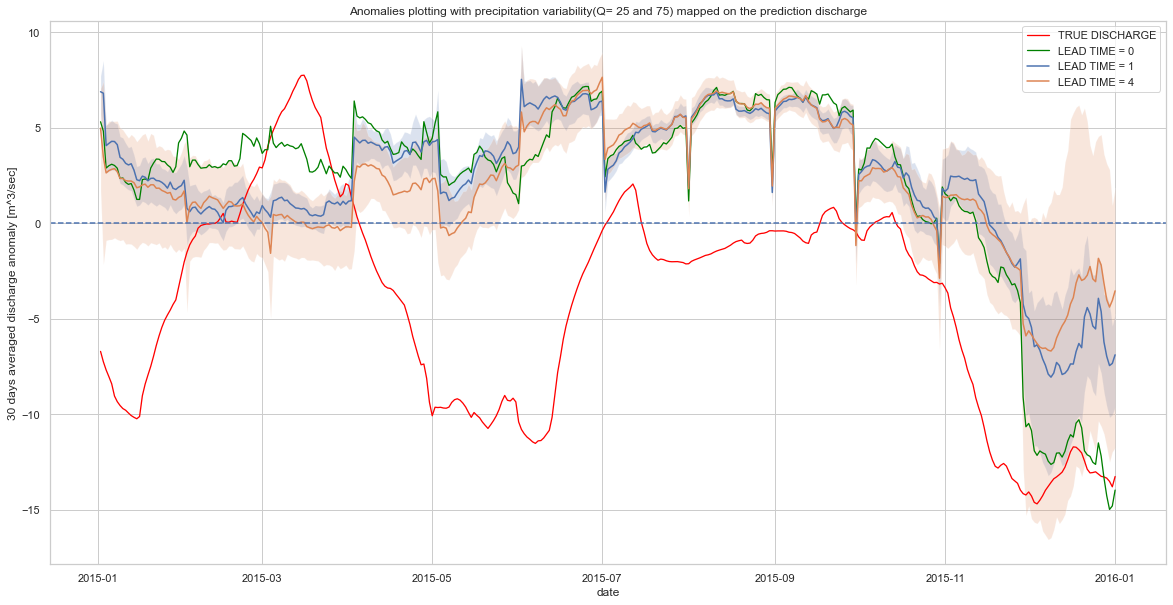

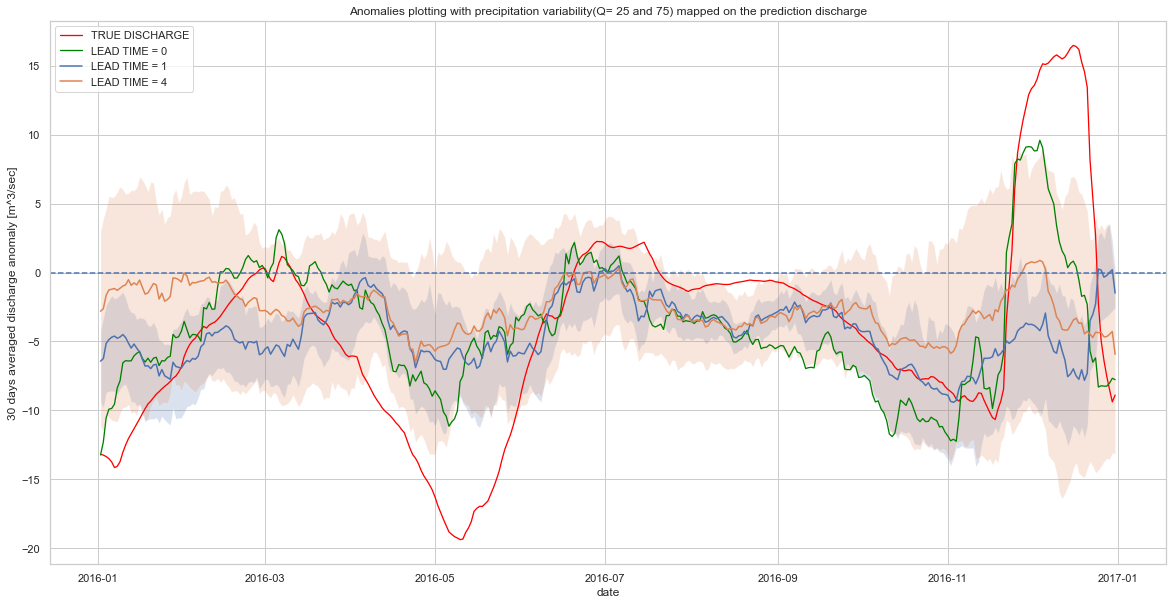

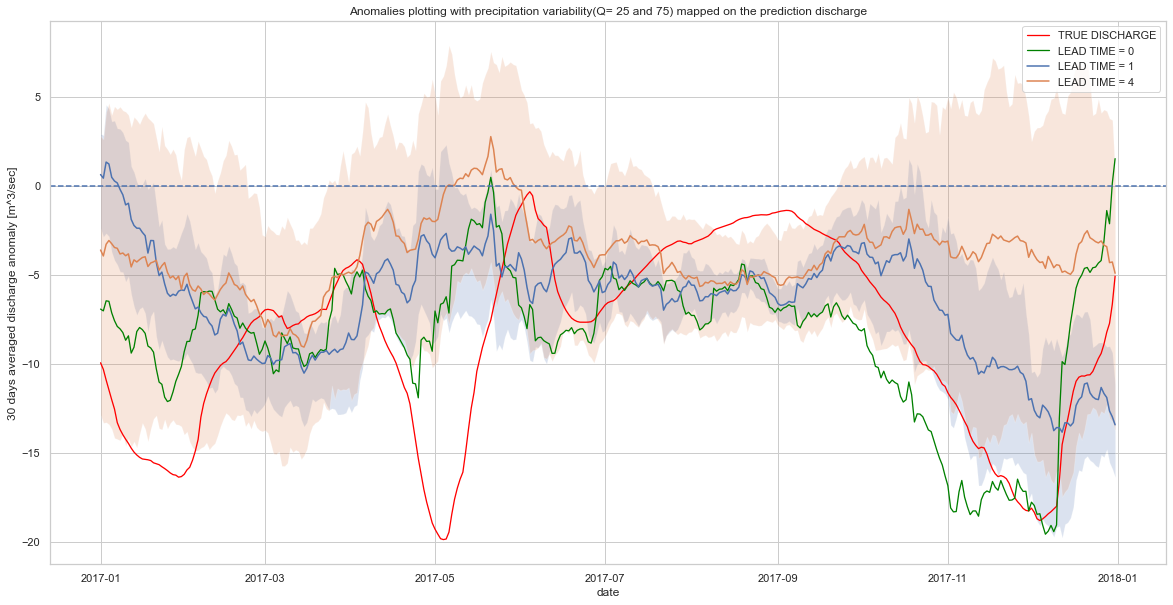

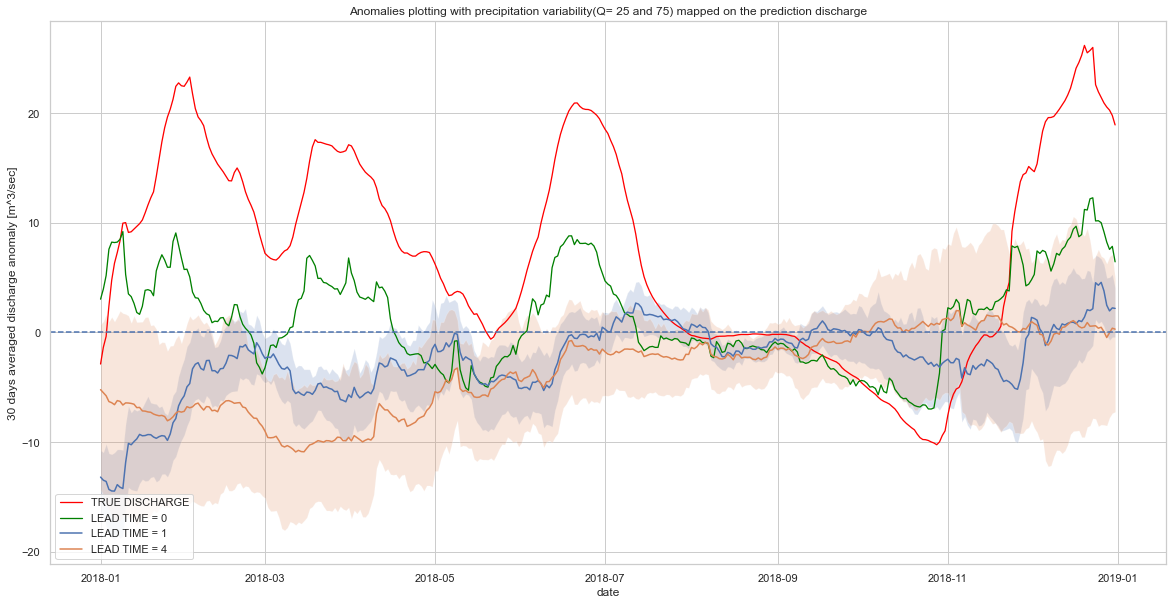

In [85]:
a3=compute_anomalies(climatologies3, predictions3)
a3['split']=predictions3.split

plot_anomalies(a3)

## D) NO_RUN, T_UNIT = 30

In [59]:
daily_input_stat4 = daily_input_stat.drop(columns=[c for c in daily_input_stat.columns if c[0]=='R'])

t_unit=30

Fitting 1 folds for each of 25 candidates, totalling 25 fits
Fitting 1 folds for each of 25 candidates, totalling 25 fits
Fitting 1 folds for each of 25 candidates, totalling 25 fits
Fitting 1 folds for each of 25 candidates, totalling 25 fits
Fitting 1 folds for each of 25 candidates, totalling 25 fits

C4=0.1
eps4=0.01


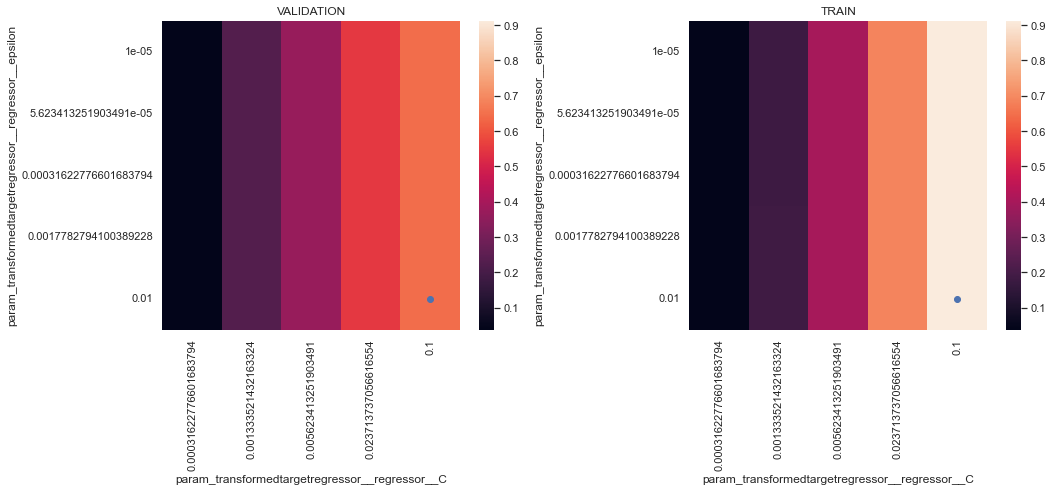

In [60]:
C4, eps4 = SVR_nested_CV_gridsearch(daily_input_stat4, C_range, epsilon_range, t_range, t_unit, n_splits, test_size)
print(f'C4={C4}')
print(f'eps4={eps4}')

C4=0.17782794100
eps4=0.316227766016

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [61]:
radius_for_ensemble = 1
predictions4 = nested_CV_SVR_predict(daily_input_stat4, C4, eps4, t_length, t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

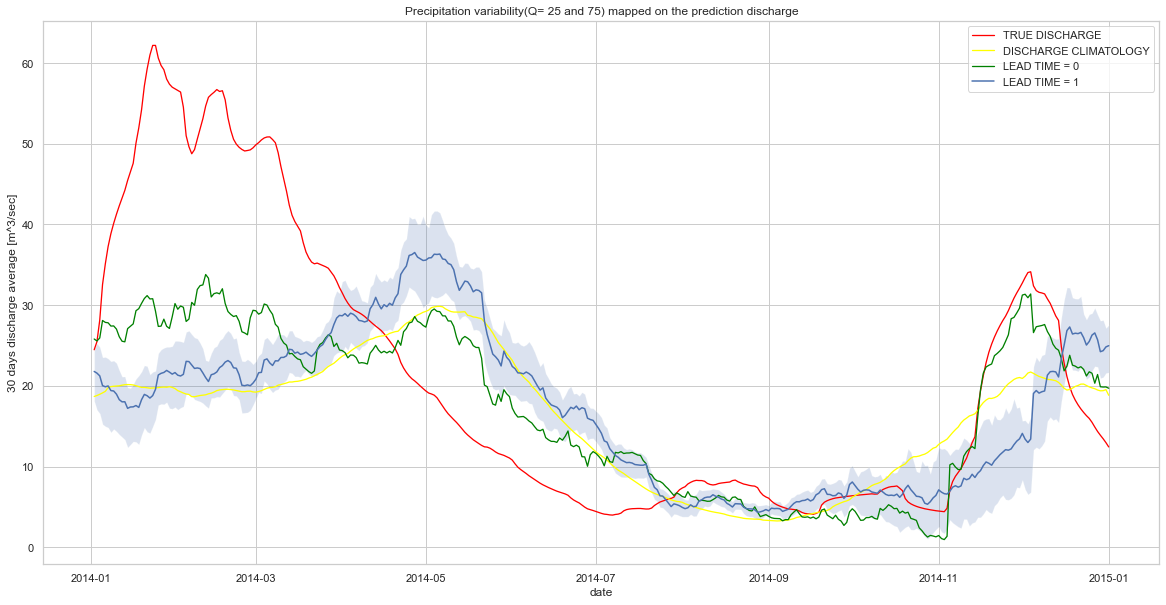

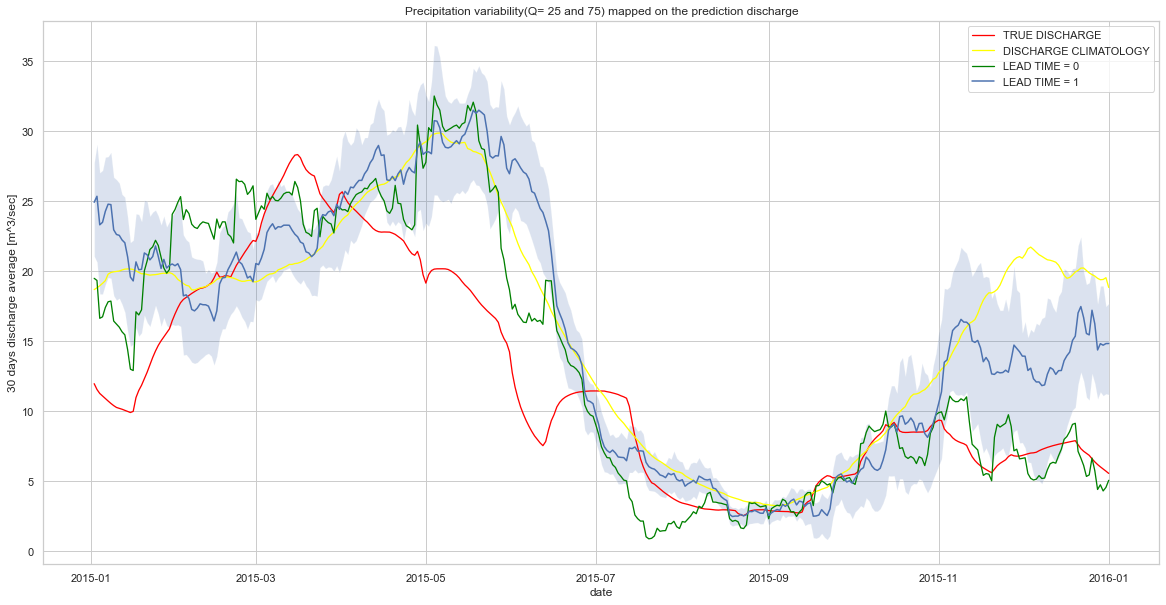

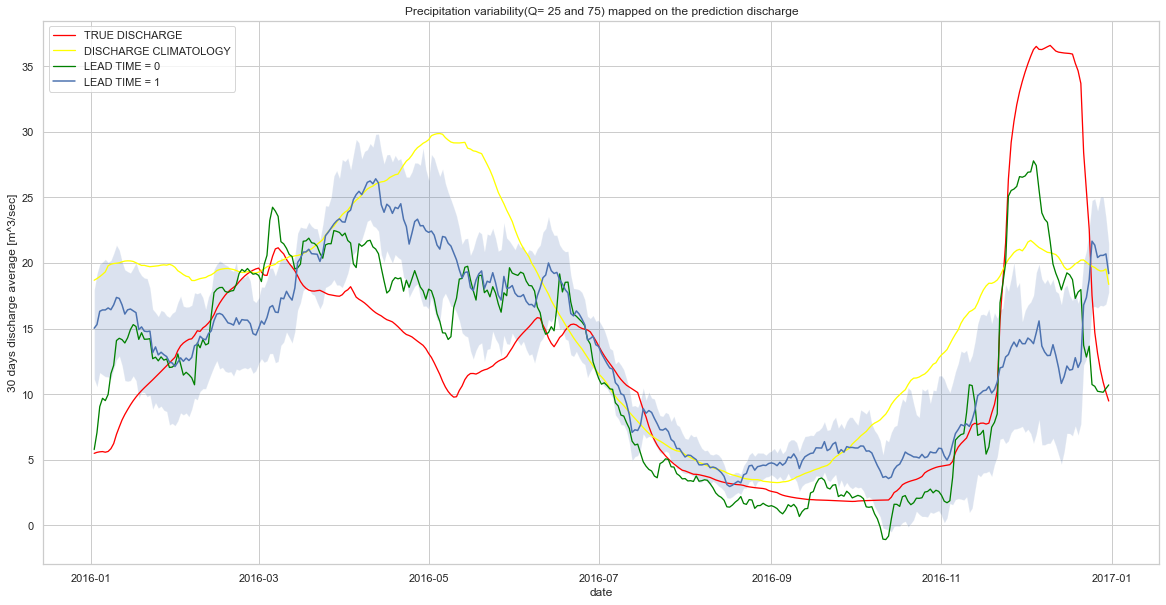

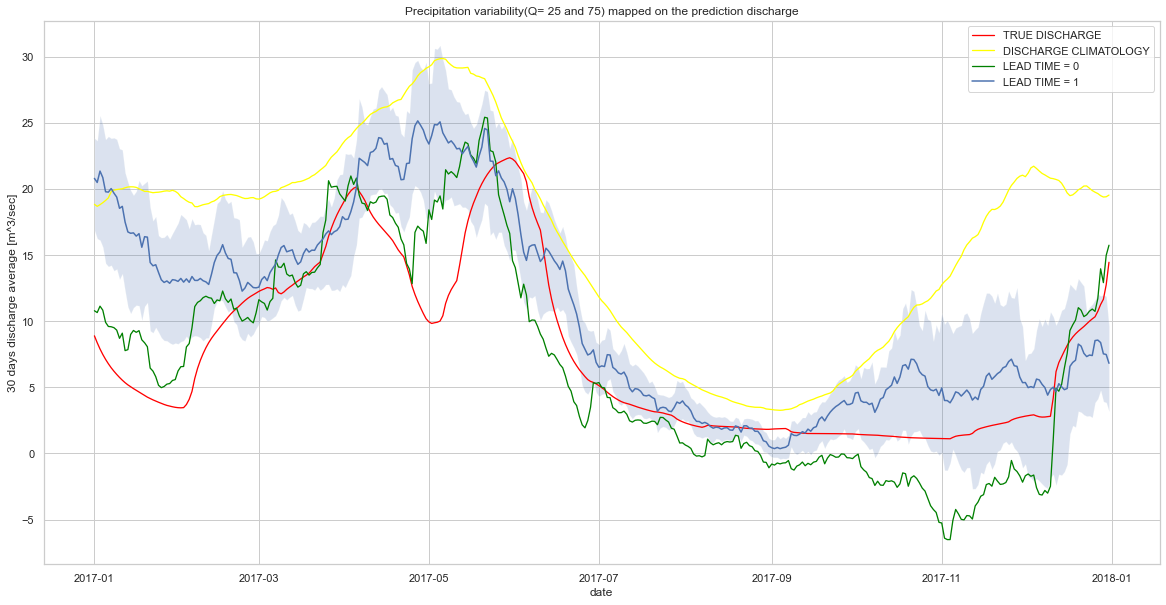

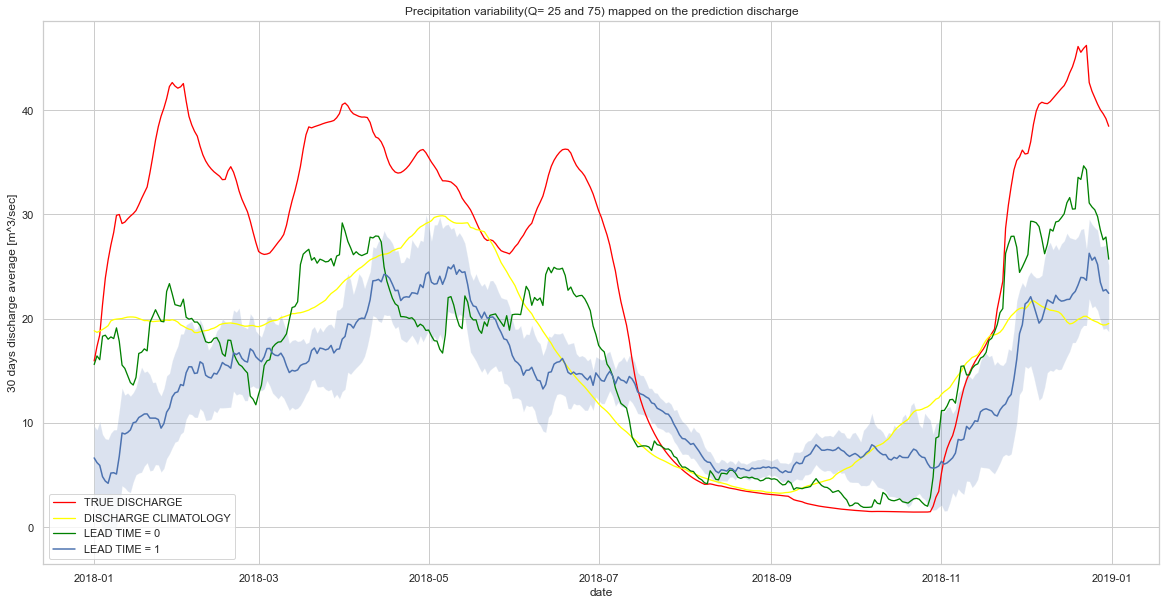

In [62]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions4)

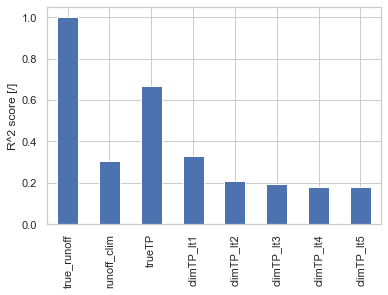

In [63]:
r2_D= evaluate_prediction(predictions4)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [64]:
predictions_for_clim4 = classic_CV_SVR_predict(daily_input_stat4, C4, eps4, t_length, t_unit, n_splits)

In [65]:
climatologies4 =predictions_for_clim4.groupby(by=predictions_for_clim4.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies4['doty']=climatologies4.index


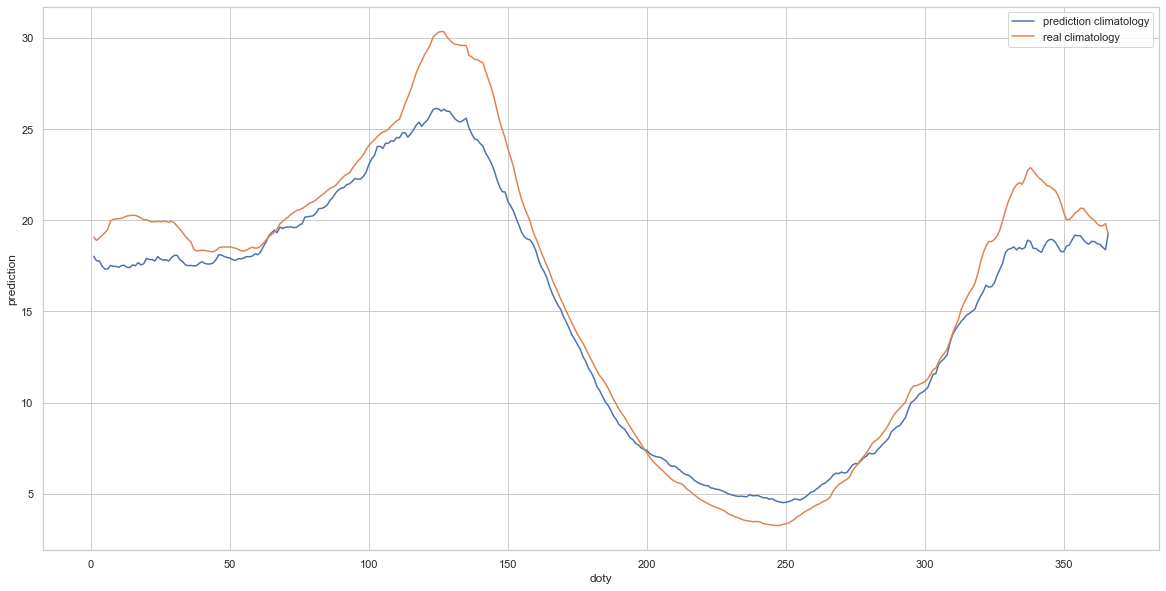

In [66]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies4,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies4,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

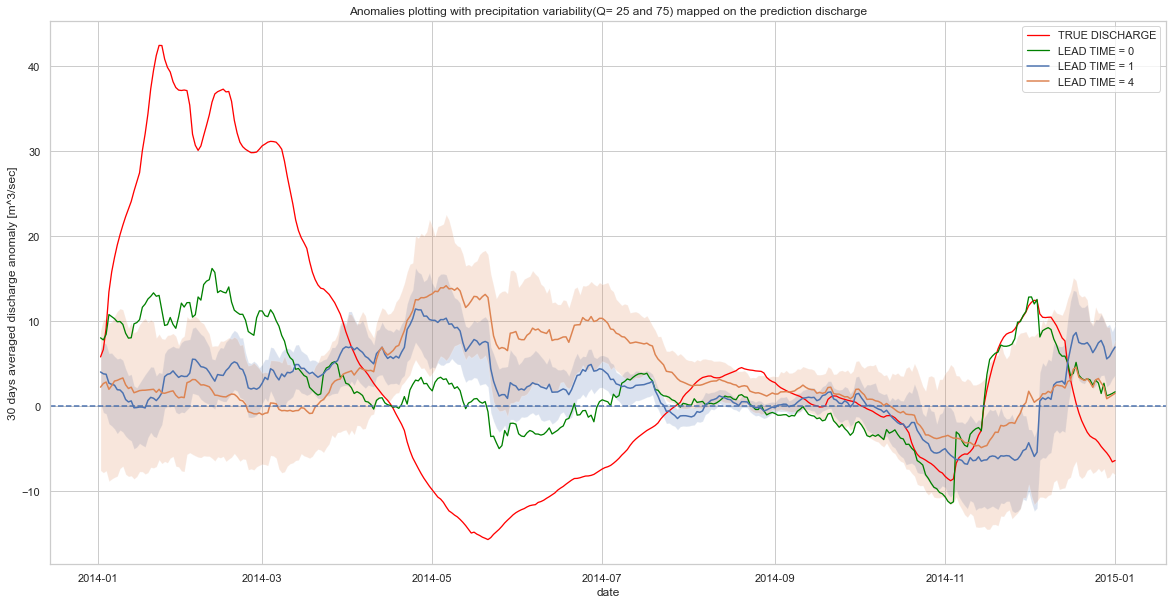

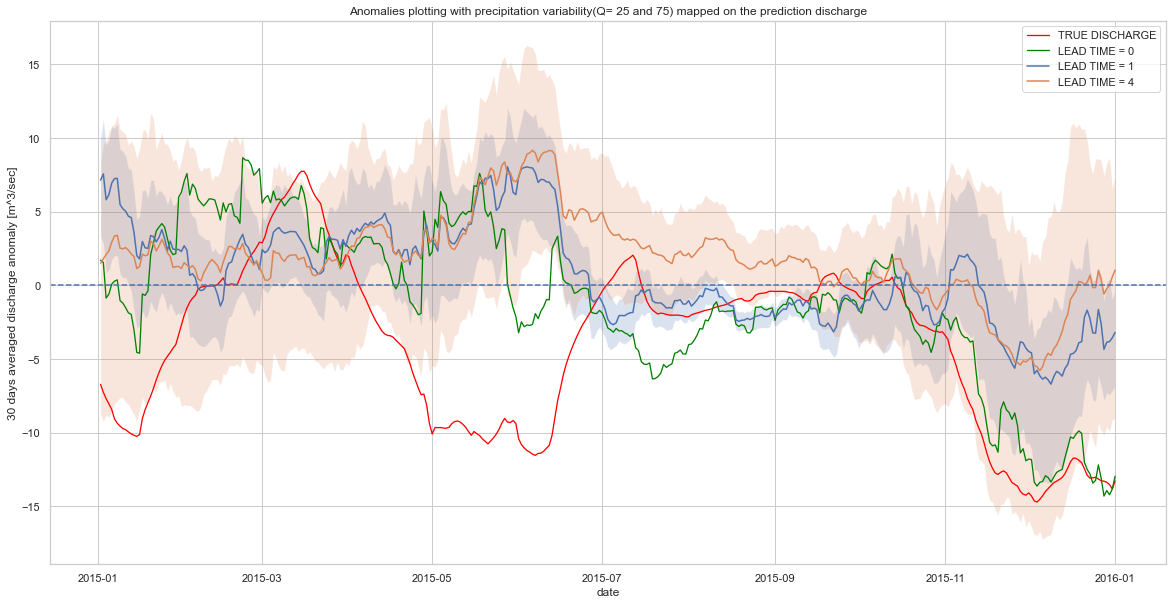

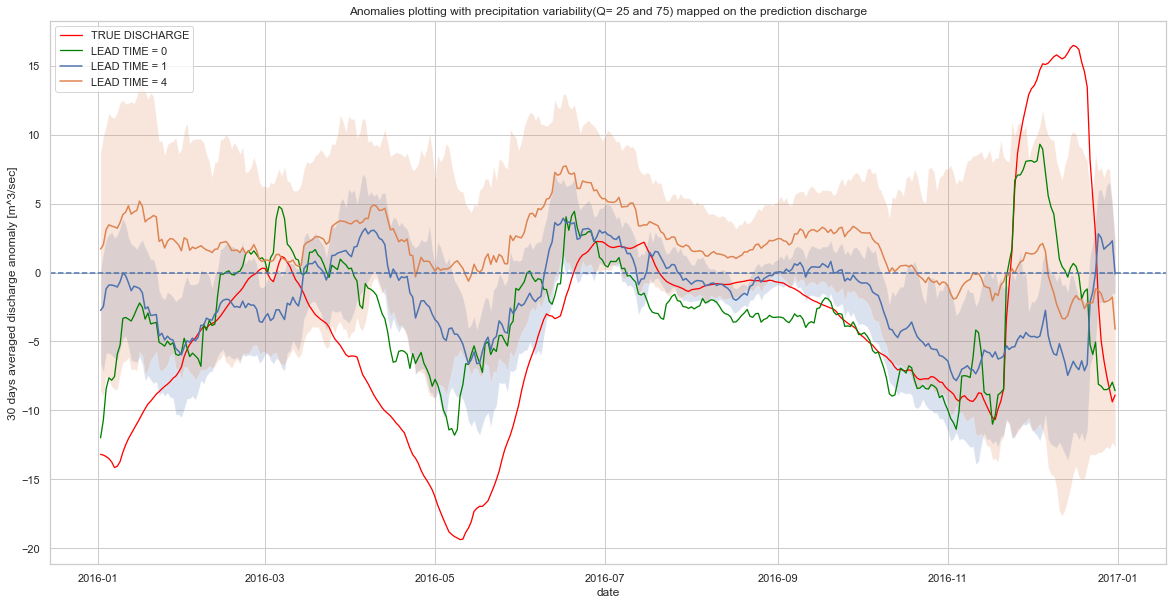

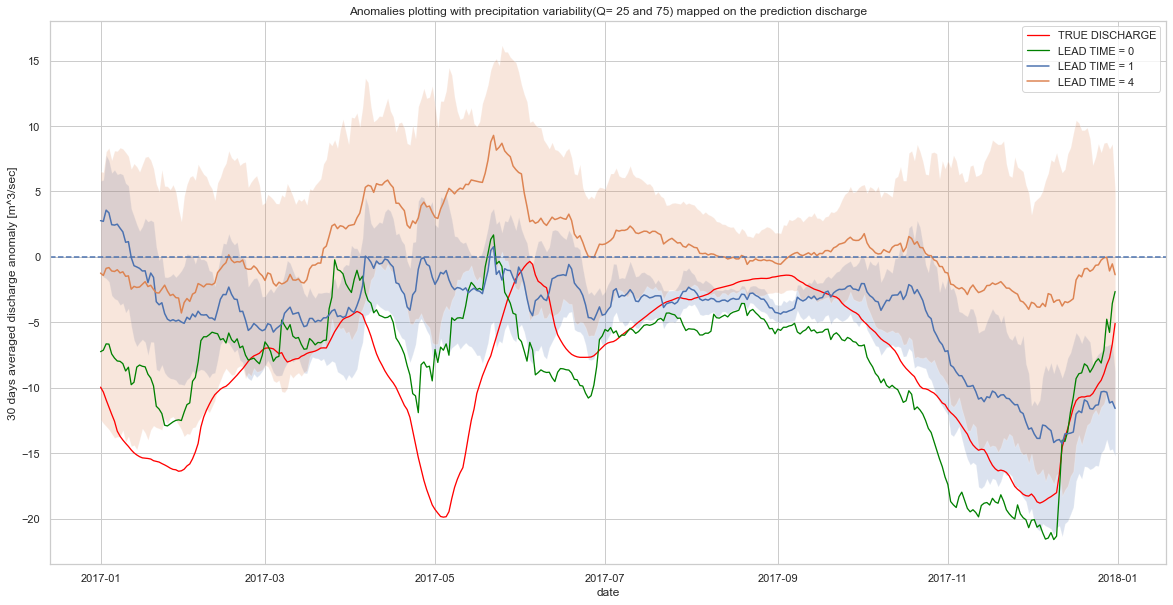

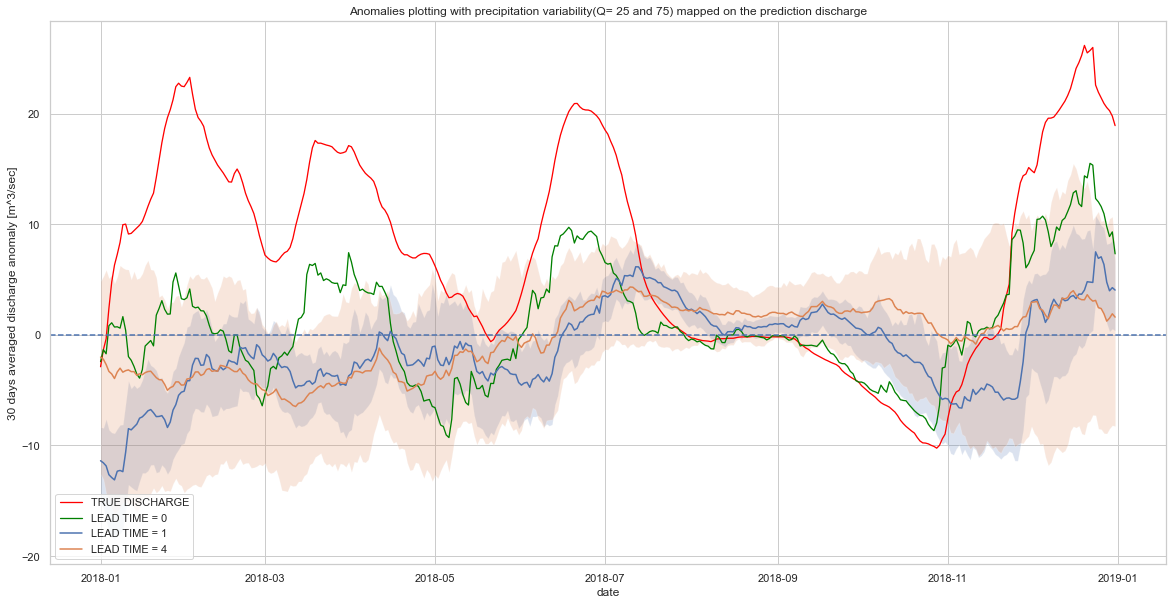

In [67]:
a4=compute_anomalies(climatologies4, predictions4)
a4['split']=predictions4.split

plot_anomalies(a4)

# COMPARE RESULTS

Text(0, 0.5, 'r^2 [/]')

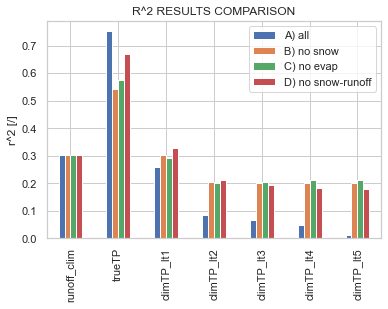

In [86]:
results = pd.concat([r2_A,r2_B,r2_C,r2_D],axis=1)
results.columns=['A) all','B) no snow','C) no evap','D) no snow-runoff']
results.iloc[1:].plot.bar()
plt.title('R^2 RESULTS COMPARISON')
plt.ylabel('r^2 [/]')

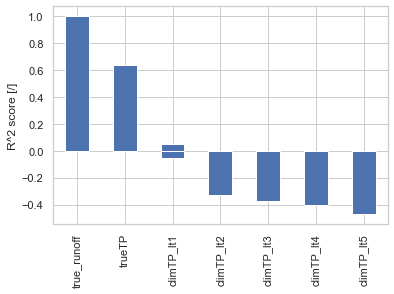

In [87]:
r2_a_D= evaluate_prediction(a4)
r2_a_C= evaluate_prediction(a3)
r2_a_B = evaluate_prediction(a2)
r2_a_A = evaluate_prediction(a)

Text(0.5, 1.0, 'R^2 RESULTS COMPARISON')

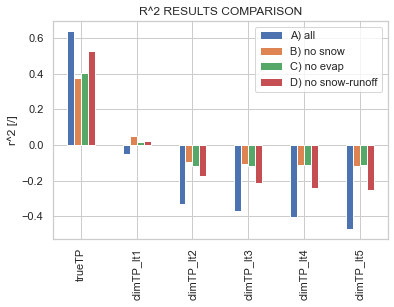

In [88]:
results_a = pd.concat([r2_a_A,r2_a_B,r2_a_C,r2_a_D],axis=1)
results_a.columns=['A) all','B) no snow','C) no evap','D) no snow-runoff']
results_a.iloc[1:].plot.bar()
plt.ylabel('r^2 [/]')
plt.title('R^2 RESULTS COMPARISON')

In [89]:
arrays = [[np.array(np.repeat((t_unit),8),dtype=object),np.array(results.index)]]
tup=np.concatenate(arrays)
index = pd.MultiIndex.from_arrays(tup, names=["t_unit" , "lt"])

results.index=index

results


A) all  B) no snow  C) no evap  D) no snow-runoff
t_unit lt                                                              
30     true_runoff  1.000000    1.000000    1.000000           1.000000
       runoff_clim  0.303719    0.303719    0.303719           0.303719
       trueTP       0.752264    0.541689    0.576628           0.668720
       climTP_lt1   0.259704    0.303311    0.290648           0.329331
       climTP_lt2   0.083609    0.206018    0.199704           0.210963
       climTP_lt3   0.064993    0.199987    0.204610           0.194239
       climTP_lt4   0.047041    0.201542    0.212672           0.181328
       climTP_lt5   0.011035    0.199293    0.211211           0.178569

In [90]:
arrays = [[np.array(np.repeat((t_unit),7),dtype=object),np.array(results_a.index)]]
tup=np.concatenate(arrays)
index = pd.MultiIndex.from_arrays(tup, names=["t_unit" , "lt"])

results_a.index=index

results_a

A) all  B) no snow  C) no evap  D) no snow-runoff
t_unit lt                                                              
30     true_runoff  1.000000    1.000000    1.000000           1.000000
       trueTP       0.638353    0.374698    0.401667           0.525152
       climTP_lt1  -0.049732    0.051982    0.017449           0.021060
       climTP_lt2  -0.329424   -0.095467   -0.119583          -0.175136
       climTP_lt3  -0.372766   -0.109408   -0.116306          -0.215508
       climTP_lt4  -0.403599   -0.110460   -0.114308          -0.244482
       climTP_lt5  -0.469762   -0.118206   -0.110370          -0.255061

In [91]:
results.to_csv('results/DROME__30.csv')
results_a.to_csv('results/DROME__30_a.csv')

## APPEND RESULTS

results = pd.concat([r2_A],axis=1)
results.columns=['E) all + runoff']
results.iloc[1:].plot.bar()
plt.title('R^2 RESULTS COMPARISON')
plt.ylabel('r^2 [/]')

r2_a_A = evaluate_prediction(a)

results_a = pd.concat([r2_a_A],axis=1)
results_a.columns=['E) all + runoff']
results_a.iloc[1:].plot.bar()
plt.ylabel('r^2 [/]')
plt.title('R^2 RESULTS COMPARISON')

arrays = [[np.array(np.repeat((t_unit),8),dtype=object),np.array(results.index)]]
tup=np.concatenate(arrays)
index = pd.MultiIndex.from_arrays(tup, names=["t_unit" , "lt"])

results.index=index

results


arrays = [[np.array(np.repeat((t_unit),7),dtype=object),np.array(results_a.index)]]
tup=np.concatenate(arrays)
index = pd.MultiIndex.from_arrays(tup, names=["t_unit" , "lt"])

results_a.index=index

results_a

results.to_csv('results/DROME__30.csv', mode='a')
results_a.to_csv('results/DROME__30_a.csv', mode='a')